In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

## **1. PREPROCESSING DATA**

### **Import data**

In [ ]:
# Read data from file
file_path = r"C:\Users\Admin\Downloads\paris_temperature.csv"
df = pd.read_csv(file_path)
pd.set_option('display.max_columns', None)

# Data exploration
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              382 non-null    object 
 1   datetime          382 non-null    object 
 2   tempmax           382 non-null    float64
 3   tempmin           382 non-null    float64
 4   temp              382 non-null    float64
 5   feelslikemax      382 non-null    float64
 6   feelslikemin      382 non-null    float64
 7   feelslike         382 non-null    float64
 8   dew               382 non-null    float64
 9   humidity          382 non-null    float64
 10  precip            382 non-null    float64
 11  precipprob        382 non-null    float64
 12  precipcover       382 non-null    float64
 13  preciptype        308 non-null    object 
 14  snow              382 non-null    float64
 15  snowdepth         382 non-null    float64
 16  windgust          382 non-null    float64
 1

In [ ]:
df.head()

name    datetime  tempmax  tempmin  temp  feelslikemax  \
0  Paris,France  2023-10-01     26.5     12.5  18.9          26.5   
1  Paris,France  2023-10-02     27.7     14.5  20.7          27.9   
2  Paris,France  2023-10-03     22.1     15.0  18.8          22.1   
3  Paris,France  2023-10-04     18.2     10.2  14.2          18.2   
4  Paris,France  2023-10-05     19.8     11.0  14.7          19.8   

   feelslikemin  feelslike   dew  humidity  precip  precipprob  precipcover  \
0          12.5       18.9  13.7      74.3   0.144       100.0         4.17   
1          14.5       20.7  14.7      71.0   0.000         0.0         0.00   
2          15.0       18.8  13.0      69.9   0.386       100.0        12.50   
3          10.2       14.2   9.3      73.2   0.006       100.0         4.17   
4          11.0       14.7   9.4      72.1   0.014       100.0         4.17   

  preciptype  snow  snowdepth  windgust  windspeed  winddir  sealevelpressure  \
0       rain   0.0        0.0      25.0       11.3    170.2            1023.7   
1        NaN   0.0        0.0      26.3       12.0    173.7            1018.8   
2       rain   0.0        0.0      51.6       22.8    277.2            1020.5   
3       rain   0.0        0.0      23.6       12.3    260.9            1029.8   
4       rain   0.0        0.0      16.3        6.8    238.3            1027.3   

   cloudcover  visibility  solarradiation  solarenergy  uvindex  severerisk  \
0        46.5        18.6            39.8          3.5        3          10   
1        48.6        16.8            51.3          4.4        4          10   
2        71.8        22.1            54.5          4.8        4          10   
3        62.0        22.4            58.9          5.1        4          10   
4        82.3        21.3            41.7          3.5        3          10   

               sunrise               sunset  moonphase  \
0  2023-10-01T07:49:34  2023-10-01T19:30:27       0.57   
1  2023-10-02T07:51:01  2023-10-02T19:28:21       0.60   
2  2023-10-03T07:52:29  2023-10-03T19:26:16       0.63   
3  2023-10-04T07:53:57  2023-10-04T19:24:10       0.66   
4  2023-10-05T07:55:25  2023-10-05T19:22:06       0.70   

               conditions                                        description  \
0  Rain, Partially cloudy  Partly cloudy throughout the day with morning ...   
1        Partially cloudy                  Partly cloudy throughout the day.   
2  Rain, Partially cloudy  Partly cloudy throughout the day with rain in ...   
3  Rain, Partially cloudy  Partly cloudy throughout the day with morning ...   
4  Rain, Partially cloudy  Partly cloudy throughout the day with morning ...   

                icon                                           stations  
0               rain  07149099999,07156099999,07146099999,0715709999...  
1  partly-cloudy-day  07149099999,07156099999,07146099999,0715709999...  
2               rain  07149099999,07156099999,07146099999,LFPV,07157...  
3               rain  07149099999,07156099999,07146099999,LFPV,07145...  
4               rain  07149099999,07156099999,07146099999,LFPV,07145...

### **Some minor checks**

#### Check if any values are mislabeled.

In [ ]:
# Temperature features
condition_temp = (df['tempmax'] > df['temp']) & (df['temp'] > df['tempmin'])

condition_feelslike = (df['feelslikemax'] > df['feelslike']) & (df['feelslike'] > df['feelslikemin'])

violations_temp = df[~condition_temp]
violations_feelslike = df[~condition_feelslike]

print(f"Number of columns tempmax > temp > tempmin: {len(violations_temp)}")
print(f"Number of columns feelslikemax > feelslike > feelslikemin: {len(violations_feelslike)}")

Number of columns tempmax > temp > tempmin: 0
Number of columns feelslikemax > feelslike > feelslikemin: 0


In [ ]:
# Humidity and Precipitation
preciptype_nan = df[df['preciptype'].isna()]

condition_precip_zeros = (
    (preciptype_nan['precip'] == 0) &
    (preciptype_nan['precipprob'] == 0) &
    (preciptype_nan['precipcover'] == 0)
)

violations = preciptype_nan[~condition_precip_zeros]

print(f"Number of columns that have preciptype NaN but precip, precipprob or precipcover NOT = 0 together: {len(violations)}")

Number of columns that have preciptype NaN but precip, precipprob or precipcover NOT = 0 together: 0


In [ ]:
inconsistent_rain_1 = df[
    (df['preciptype'] == 'rain') &
    (df['precip'] == 0) &
    (df['precipprob'] == 0) &
    (df['precipcover'] == 0)
]

print(f"Number of columns have precip, precipprob and precipcover = 0: {len(inconsistent_rain_1)}")

Number of columns have precip, precipprob and precipcover = 0: 25


Wrong label for preciptype because 3 features show that there was no rain but preciptype was rain

In [ ]:
inconsistent_rain_2 = df[
    (df['preciptype'] == 'rain') &
    (df['precip'] == 0) &
    (df['precipcover'] == 0) &
    (df['precipprob'] > 0)
]
print(f"Number of columns that have precip and precipcover = 0 and precipprob > 0: {len(inconsistent_rain_2)}")

Number of columns that have precip and precipcover = 0 and precipprob > 0: 2


Wrong label

In [ ]:
df.loc[
    (df['precip'] == 0) &
    (df['precipcover'] == 0),
    'preciptype'
] = 'no precipitation'

In [ ]:
df['preciptype'].isna().sum()

0

In [ ]:
df['preciptype'].unique()

array(['rain', 'no precipitation', 'rain,snow', 'rain,freezingrain,snow'],
      dtype=object)

In [ ]:
# Snow features
mask_snow_wrong = df[
    df['preciptype'].str.contains('snow', na=False) &
    (df['snow'] == 0) &
    (df['snowdepth'] == 0)
]

print(f"Number of columns that have snow and snowdepth = 0 but preciptype have snow: {len(mask_snow_wrong)}")

Number of columns that have snow and snowdepth = 0 but preciptype have snow: 0


#### Handle datetime values

In [ ]:
# Convert datetime column to datetime type
df["datetime"] = pd.to_datetime(df["datetime"], errors='coerce')
# Sort data by datetime
df = df.sort_values(by='datetime')

In [ ]:
df["sunrise"] = pd.to_datetime(df["sunrise"], errors='coerce')
df["sunset"] = pd.to_datetime(df["sunset"], errors='coerce')

In [ ]:
# Extract useful time features
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["dayofweek"] = df["datetime"].dt.dayofweek

#### Handle missing values

In [ ]:
# Check for missing values
missing_columns = df.columns[df.isnull().any()]
print("Columns with missing values:", missing_columns.tolist())

Columns with missing values: ['stations']


In [ ]:
# 'stations' column: Fill with "Unknown".
df['stations'].fillna('Unknown', inplace=True)

# Check again if there are any null values left.
df.isnull().sum().sum()

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\1488144971.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['stations'].fillna('Unknown', inplace=True)


0

### **Visualize data**

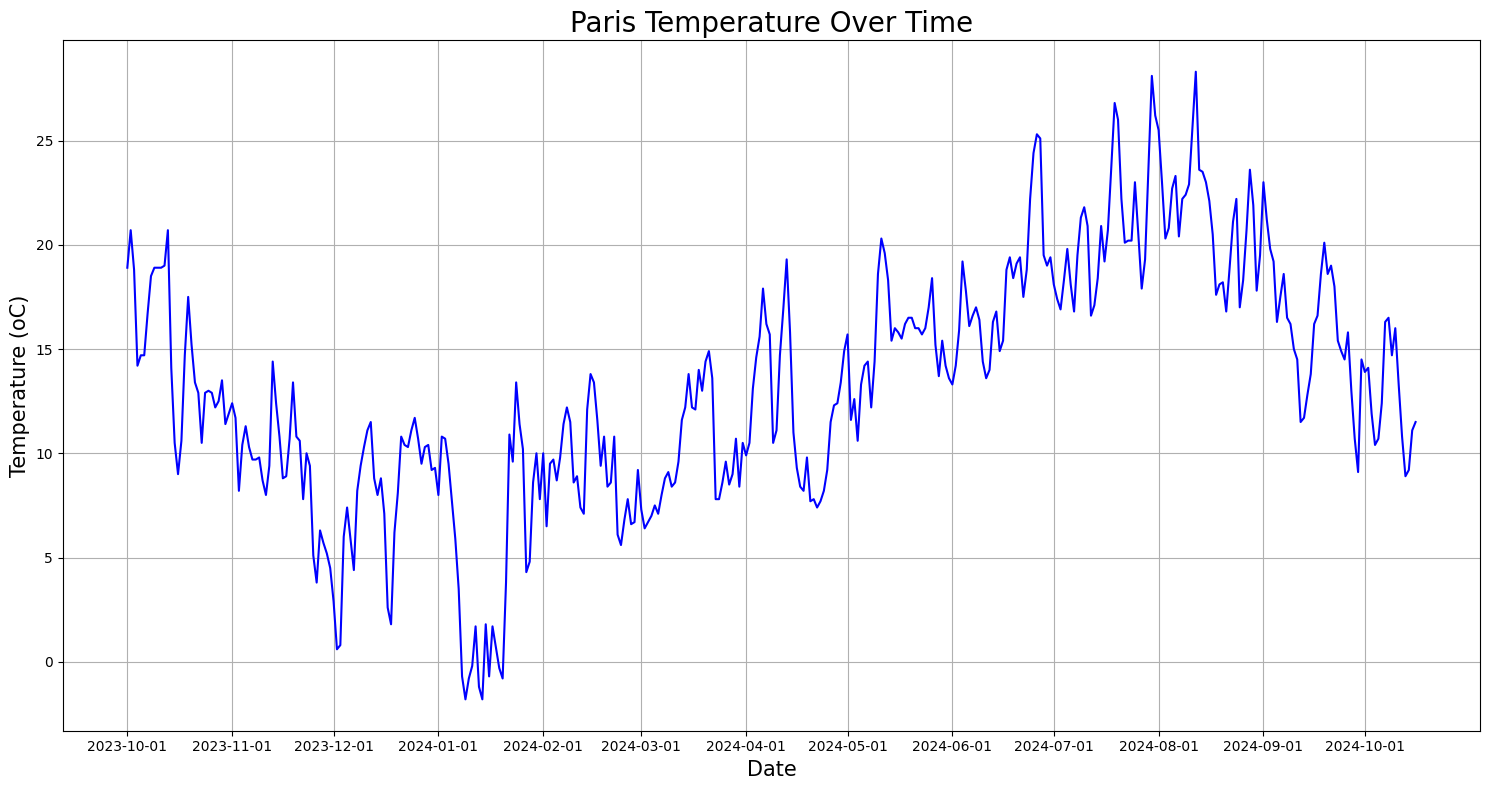

In [ ]:
# 1. Linegraph of temperature over time
custom_ticks = pd.date_range(start="2023-10-01", end="2024-10-01", freq='MS') #list các ngày đầu tháng từ 1/10/2023 đến 1/10/2024

plt.figure(figsize=(15, 8))
plt.plot(df['datetime'], df['temp'], color='blue')
plt.title("Paris Temperature Over Time", fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature (oC)', fontsize=15)
plt.xticks(custom_ticks)
plt.grid()
plt.tight_layout()
plt.show()

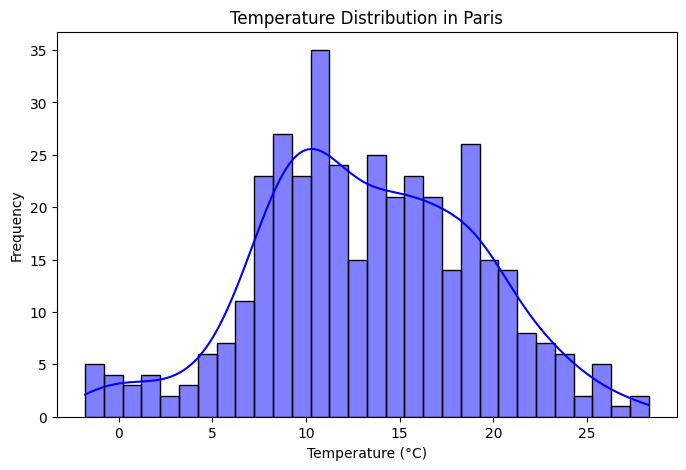

In [ ]:
# 2. Histogram of temperature
plt.figure(figsize=(8, 5))
sns.histplot(df["temp"], bins=30, kde=True, color="b")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.title("Temperature Distribution in Paris")
plt.show()

=> The temperature distribution is nearly normally distributed, with the majority of values falling between 10°C and 20°C.

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4255763209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="month", y="temp", data=df, palette="coolwarm")


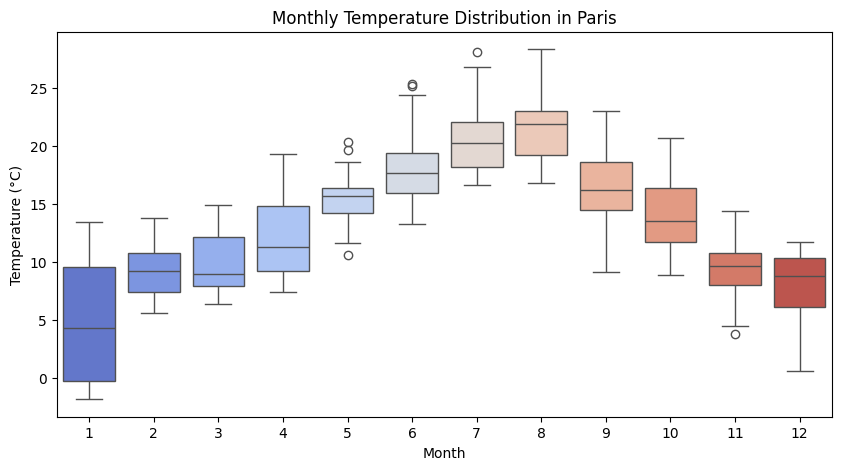

In [ ]:
# 3. Plot monthly temperature trends to check for seasonality
plt.figure(figsize=(10, 5))
sns.boxplot(x="month", y="temp", data=df, palette="coolwarm")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.title("Monthly Temperature Distribution in Paris")
plt.show()

=>  There is a clear seasonality, with the highest temperatures in the summer (June-August) and the lowest temperatures in the winter (December-February).

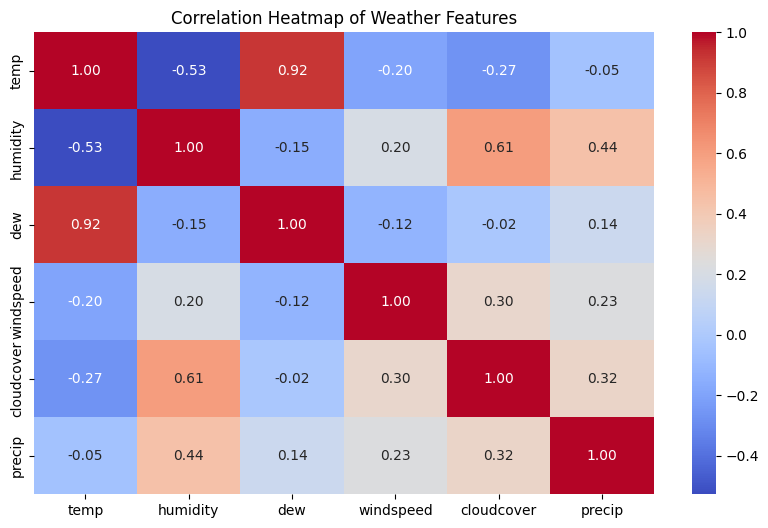

In [ ]:
# 4. Features correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[["temp", "humidity", "dew", "windspeed", "cloudcover", "precip"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Weather Features")
plt.show()

=> Correlation between variables:
* Temperature and dew point have the strongest linear relationship, indicating that air humidity significantly affects temperature.
* Temperature and humidity have a negative correlation, meaning hot days are often less humid.
* Precipitation is related to cloud cover, but not all cloudy days have rain.
* Wind speed has a minor influence on temperature."

## **2. COLUMN'S MEANING**

#### 1. General Information
- **`name`**: Name of the location ("Paris, France").
- **`datetime`**: Date of the observation (in YYYY-MM-DD format).

#### 2. Temperature Features
- **`tempmax`**: Maximum temperature of the day (°C).
- **`tempmin`**: Minimum temperature of the day (°C).
- **`temp`**: Average temperature of the day (°C).
- **`feelslikemax`**: Maximum "feels like" temperature considering wind and humidity (°C).
- **`feelslikemin`**: Minimum "feels like" temperature (°C).
- **`feelslike`**: Average "feels like" temperature (°C).
- **`dew`**: Dew point temperature (°C), indicating humidity levels. Dew point is the temperature at which the air becomes saturated with water vapor and condensation begins to form dew, fog, or clouds, thus it can predict the fog, cloud or rain (eg: When the dew point is 13.7°C, it means that if the air temperature drops to 13.7°C, water vapor in the air will begin to condense into liquid water.)

#### 3. Humidity & Precipitation
- **`humidity`**: Average relative humidity (%).
- **`precip`**: Total precipitation (mm) for the day.
- **`precipprob`**: Probability of precipitation (%).
- **`precipcover`**: Percentage of the day covered by precipitation.
- **`preciptype`**: Type of precipitation (e.g., rain, snow, or missing values).

#### 4. Snow Information
- **`snow`**: Snowfall amount (mm).
- **`snowdepth`**: Snow depth on the ground (mm).

#### 5. Wind Information
- **`windgust`**: Maximum wind gust speed (km/h).
- **`windspeed`**: Average wind speed (km/h).
- **`winddir`**: Wind direction in degrees (0° = North, 90° = East, etc.).

#### 6. Atmospheric Conditions
- **`sealevelpressure`**: Sea-level atmospheric pressure (hPa).
- **`cloudcover`**: Average cloud cover percentage.
- **`visibility`**: Average visibility distance (km).

#### 7. Solar & UV Data
- **`solarradiation`**: Solar radiation in W/m².
- **`solarenergy`**: Total solar energy received (MJ/m²).
- **`uvindex`**: Maximum UV index for the day.

#### 8. Severe Weather Risk
- **`severerisk`**: Risk level of severe weather.

#### 9. Sun & Moon Data
- **`sunrise`**: Sunrise time (ISO format) (eg: 2023-10-27T14:30:00).
- **`sunset`**: Sunset time (ISO format).
- **`moonphase`**: Phase of the moon
  - 0 or 1 = 🌑 New Moon - the moon is not visible from Earth.
  - 0.01 - 0.24 = 🌒 Waxing Crescent - A small part of the Moon becomes visible on the right side.
  - 0.25 = 🌓 First Quarter - Half of the Moon is visible (right side).
  - 0.26 - 0.49 = 🌔 More than half of the Moon is visible, leading up to a Full Moon.
  - 0.5 = 🌕 Full Moon - The Moon is fully illuminated.
  - 0.51 - 0.74 = 🌖 The Moon starts shrinking (left side).
  - 0.75 = 🌗 Last Quarter - Half of the Moon is visible (left side).
  - 0.76 - 0.99 = 🌘 A small part of the Moon remains visible before New Moon.

#### 10. Weather Description
- **`conditions`**: General weather conditions (e.g., "Rain, Partially cloudy").
- **`description`**: More detailed weather description.
- **`icon`**: Symbolic representation of weather (e.g., "rain", "partly-cloudy-day").

#### 11. Weather Station Data
- **`stations`**: Weather station's identification code (eg:07149099999) that provided the data. (If the data is from an unidentified station, fill the value with 'unknown'.)



## **3. FEATURE'S TYPE (NUMERIRCAL OR CATEGORICAL)**

In [ ]:
# Automatically detect numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Count features in each category
numerical_count = len(numerical_features)
categorical_count = len(categorical_features)

# Create DataFrame with maximum length of the longer list
max_len = max(len(numerical_features), len(categorical_features))
feature_table = pd.DataFrame({
    "Numerical Features": numerical_features + [""] * (max_len - len(numerical_features)),
    "Categorical Features": categorical_features + [""] * (max_len - len(categorical_features))
})

# Detect numerical and categorical features
print(f"- Total Numerical Features: {numerical_count}")
print(f"- Total Categorical Features: {categorical_count}")
print("- Features:")
print(feature_table)
print("- In time series, the datetime column is a temporal feature, not purely numerical or categorical")

- Total Numerical Features: 24
- Total Categorical Features: 6
- Features:
   Numerical Features Categorical Features
0             tempmax                 name
1             tempmin           preciptype
2                temp           conditions
3        feelslikemax          description
4        feelslikemin                 icon
5           feelslike             stations
6                 dew                     
7            humidity                     
8              precip                     
9          precipprob                     
10        precipcover                     
11               snow                     
12          snowdepth                     
13           windgust                     
14          windspeed                     
15            winddir                     
16   sealevelpressure                     
17         cloudcover                     
18         visibility                     
19     solarradiation                     
20        solarenergy 

In [ ]:
df[['precipprob', 'precipcover','preciptype', 'conditions', 'description', 'icon']]

precipprob  precipcover        preciptype              conditions  \
0         100.0         4.17              rain  Rain, Partially cloudy   
1           0.0         0.00  no precipitation        Partially cloudy   
2         100.0        12.50              rain  Rain, Partially cloudy   
3         100.0         4.17              rain  Rain, Partially cloudy   
4         100.0         4.17              rain  Rain, Partially cloudy   
..          ...          ...               ...                     ...   
377        45.2         0.00  no precipitation  Rain, Partially cloudy   
378        38.7        16.67              rain                Overcast   
379        32.3        25.00              rain                Overcast   
380        22.6        16.67              rain                Overcast   
381        19.4        20.83              rain        Partially cloudy   

                                           description               icon  
0    Partly cloudy throughout the day with morning ...               rain  
1                    Partly cloudy throughout the day.  partly-cloudy-day  
2    Partly cloudy throughout the day with rain in ...               rain  
3    Partly cloudy throughout the day with morning ...               rain  
4    Partly cloudy throughout the day with morning ...               rain  
..                                                 ...                ...  
377  Partly cloudy throughout the day with a chance...               rain  
378                   Cloudy skies throughout the day.             cloudy  
379                   Cloudy skies throughout the day.             cloudy  
380                   Cloudy skies throughout the day.             cloudy  
381                  Partly cloudy throughout the day.  partly-cloudy-day  

[382 rows x 6 columns]

In [ ]:
df['conditions'].unique()

array(['Rain, Partially cloudy', 'Partially cloudy', 'Clear',
       'Rain, Overcast', 'Overcast', 'Snow, Rain, Overcast',
       'Snow, Rain, Partially cloudy',
       'Snow, Rain, Freezing Drizzle/Freezing Rain, Partially cloudy'],
      dtype=object)

In [ ]:
def map_conditions_final(row, unique_conditions):
    base_condition = row['conditions']
    preciptype = row['preciptype']

    if preciptype == 'no precipitation':
        precip_keywords = ['Rain', 'Snow', 'Freezing Drizzle', 'Freezing Rain']
        condition_parts = [c.strip() for c in base_condition.split(',')]
        filtered_parts = [part for part in condition_parts if part not in precip_keywords]

        return ', '.join(filtered_parts) if filtered_parts else 'Clear'

    precip_raw = [pt.strip().lower() for pt in preciptype.split(',')]

    normalize_map = {
        'snow': 'Snow',
        'rain': 'Rain',
        'freezing drizzle': 'Freezing Drizzle/Freezing Rain',
        'freezing rain': 'Freezing Drizzle/Freezing Rain'
    }

    weather_order = ['Snow', 'Rain', 'Freezing Drizzle/Freezing Rain']

    normalized_precips = [normalize_map[pt] for pt in precip_raw if pt in normalize_map]

    ordered_precips = [w for w in weather_order if w in normalized_precips]

    new_cond = f"{', '.join(ordered_precips)}, {base_condition}"

    for uc in unique_conditions:
        if set(uc.lower().split(', ')) == set(new_cond.lower().split(', ')):
            return uc

    return new_cond

In [ ]:
unique_conditions = [
        'Rain, Partially cloudy',
        'Partially cloudy',
        'Clear',
        'Rain, Overcast',
        'Overcast',
        'Snow, Rain, Overcast',
        'Snow, Rain, Partially cloudy',
        'Snow, Rain, Freezing Drizzle/Freezing Rain, Partially cloudy'
    ]

df['new_conditions'] = df.apply(lambda row: map_conditions_final(row, unique_conditions), axis=1)

In [ ]:
df[['precipprob', 'precipcover','preciptype', 'conditions', 'new_conditions', 'description', 'icon']].head(20)

precipprob  precipcover        preciptype              conditions  \
0        100.0         4.17              rain  Rain, Partially cloudy   
1          0.0         0.00  no precipitation        Partially cloudy   
2        100.0        12.50              rain  Rain, Partially cloudy   
3        100.0         4.17              rain  Rain, Partially cloudy   
4        100.0         4.17              rain  Rain, Partially cloudy   
5        100.0         4.17              rain  Rain, Partially cloudy   
6          0.0         0.00  no precipitation                   Clear   
7        100.0         4.17              rain  Rain, Partially cloudy   
8          0.0         0.00  no precipitation        Partially cloudy   
9          0.0         0.00  no precipitation        Partially cloudy   
10       100.0         4.17              rain  Rain, Partially cloudy   
11       100.0        12.50              rain          Rain, Overcast   
12       100.0        16.67              rain          Rain, Overcast   
13       100.0        20.83              rain  Rain, Partially cloudy   
14       100.0         4.17              rain  Rain, Partially cloudy   
15         0.0         0.00  no precipitation        Partially cloudy   
16         0.0         0.00  no precipitation        Partially cloudy   
17       100.0        25.00              rain          Rain, Overcast   
18       100.0        16.67              rain          Rain, Overcast   
19       100.0        54.17              rain          Rain, Overcast   

            new_conditions                                        description  \
0   Rain, Partially cloudy  Partly cloudy throughout the day with morning ...   
1         Partially cloudy                  Partly cloudy throughout the day.   
2   Rain, Partially cloudy  Partly cloudy throughout the day with rain in ...   
3   Rain, Partially cloudy  Partly cloudy throughout the day with morning ...   
4   Rain, Partially cloudy  Partly cloudy throughout the day with morning ...   
5   Rain, Partially cloudy  Partly cloudy throughout the day with morning ...   
6                    Clear               Clear conditions throughout the day.   
7   Rain, Partially cloudy  Partly cloudy throughout the day with morning ...   
8         Partially cloudy                  Partly cloudy throughout the day.   
9         Partially cloudy                  Partly cloudy throughout the day.   
10  Rain, Partially cloudy  Partly cloudy throughout the day with late aft...   
11          Rain, Overcast  Cloudy skies throughout the day with morning r...   
12          Rain, Overcast         Cloudy skies throughout the day with rain.   
13  Rain, Partially cloudy        Partly cloudy throughout the day with rain.   
14  Rain, Partially cloudy  Partly cloudy throughout the day with morning ...   
15        Partially cloudy                  Partly cloudy throughout the day.   
16        Partially cloudy                  Partly cloudy throughout the day.   
17          Rain, Overcast         Cloudy skies throughout the day with rain.   
18          Rain, Overcast         Cloudy skies throughout the day with rain.   
19          Rain, Overcast  Cloudy skies throughout the day with a chance ...   

                 icon  
0                rain  
1   partly-cloudy-day  
2                rain  
3                rain  
4                rain  
5                rain  
6           clear-day  
7                rain  
8   partly-cloudy-day  
9   partly-cloudy-day  
10               rain  
11               rain  
12               rain  
13               rain  
14               rain  
15  partly-cloudy-day  
16  partly-cloudy-day  
17               rain  
18               rain  
19               rain

In [ ]:
count = df[(df['precipcover'] == 0) & (df['snow'] > 0)].shape[0]
print("Number of columns precipcover = 0 and snow > 0:", count)

Number of columns precipcover = 0 and snow > 0: 2


In [ ]:
df[(df['precipcover'] == 0) & (df['snow'] > 0)]

name   datetime  tempmax  tempmin  temp  feelslikemax  \
105  Paris,France 2024-01-14     -0.2     -3.0  -1.8          -2.6   
106  Paris,France 2024-01-15      4.6     -0.4   1.8           0.9   

     feelslikemin  feelslike  dew  humidity  precip  precipprob  precipcover  \
105          -5.6       -4.4 -3.5      88.0     0.0         0.0          0.0   
106          -3.0       -0.9 -2.8      73.5     0.0         0.0          0.0   

           preciptype  snow  snowdepth  windgust  windspeed  winddir  \
105  no precipitation   0.1        0.0      22.1       11.8    207.5   
106  no precipitation   0.1        0.0      43.1       19.0    310.0   

     sealevelpressure  cloudcover  visibility  solarradiation  solarenergy  \
105            1016.1       100.0         6.4            12.5          0.9   
106            1011.3        77.8        15.8            43.2          3.7   

     uvindex  severerisk             sunrise              sunset  moonphase  \
105        1          10 2024-01-14 08:39:57 2024-01-14 17:19:31       0.10   
106        3          10 2024-01-15 08:39:17 2024-01-15 17:20:55       0.14   

           conditions                        description               icon  \
105          Overcast   Cloudy skies throughout the day.             cloudy   
106  Partially cloudy  Partly cloudy throughout the day.  partly-cloudy-day   

                                              stations  year  month  day  \
105  07149099999,07156099999,07146099999,0715709999...  2024      1   14   
106  07149099999,07156099999,07146099999,0715709999...  2024      1   15   

     dayofweek    new_conditions  
105          6          Overcast  
106          0  Partially cloudy

In [ ]:
df.loc[(df['precipcover'] == 0) & (df['snow'] > 0), 'snow'] = 0.0

In [ ]:
count = df[(df['precipcover'] == 0) & (df['snow'] > 0)].shape[0]
print("Number of columns that precipcover = 0 and snow > 0:", count)

Number of columns that precipcover = 0 and snow > 0: 0


In [ ]:
mask = (df['snow'] > 0) & (~df['preciptype'].astype(str).str.contains('snow', case=False, na=False))
df_snow_mismatch = df[mask]
print(f"Number of columns have snow > 0 but preciptype don't have 'snow': {len(df_snow_mismatch)}")
df_snow_mismatch[['precip', 'snow', 'preciptype', 'precipcover', 'precip', 'conditions', 'description']]

Number of columns have snow > 0 but preciptype don't have 'snow': 1


precip  snow preciptype  precipcover  precip      conditions  \
64   9.843   0.3       rain        45.83   9.843  Rain, Overcast   

                                          description  
64  Cloudy skies throughout the day with a chance ...

In [ ]:
# Tìm index của dòng cần sửa
idx = df[(df['snow'] > 0) & (~df['preciptype'].astype(str).str.contains('snow', case=False, na=False))].index

# Cập nhật giá trị ở cột preciptype thành 'rain,snow'
df.loc[idx, 'preciptype'] = 'rain,snow'

In [ ]:
mask = (df['snow'] > 0) & (~df['preciptype'].astype(str).str.contains('snow', case=False, na=False))
df_snow_mismatch = df[mask]
print(f"Number of columns have snow > 0 but preciptype don't have 'snow': {len(df_snow_mismatch)}")
df_snow_mismatch[['precip', 'snow', 'preciptype', 'precipcover', 'precip', 'conditions', 'description']]

Number of columns have snow > 0 but preciptype don't have 'snow': 0


Empty DataFrame
Columns: [precip, snow, preciptype, precipcover, precip, conditions, description]
Index: []

In [ ]:
df['icon'].unique()

array(['rain', 'partly-cloudy-day', 'clear-day', 'cloudy', 'snow'],
      dtype=object)

In [ ]:
df['new_conditions'].unique()

array(['Rain, Partially cloudy', 'Partially cloudy', 'Clear',
       'Rain, Overcast', 'Overcast', 'Snow, Rain, Overcast',
       'Snow, Rain, Partially cloudy',
       'Snow, Rain, Freezing Drizzle/Freezing Rain, Partially cloudy'],
      dtype=object)

In [ ]:
df[['precipprob', 'precipcover','preciptype', 'conditions', 'new_conditions', 'description', 'icon']].tail(20)

precipprob  precipcover        preciptype              conditions  \
362       100.0        29.17              rain  Rain, Partially cloudy   
363       100.0         8.33              rain  Rain, Partially cloudy   
364         0.0         0.00  no precipitation        Partially cloudy   
365       100.0         8.33              rain          Rain, Overcast   
366         0.0         0.00  no precipitation        Partially cloudy   
367        32.3         8.33              rain        Partially cloudy   
368         3.2         4.17              rain        Partially cloudy   
369         0.0         0.00  no precipitation        Partially cloudy   
370         0.0         0.00  no precipitation        Partially cloudy   
371        35.5        29.17              rain                Overcast   
372        51.6        25.00              rain          Rain, Overcast   
373        51.6        20.83              rain          Rain, Overcast   
374        54.8        16.67              rain          Rain, Overcast   
375        54.8        29.17              rain          Rain, Overcast   
376        45.2         0.00  no precipitation  Rain, Partially cloudy   
377        45.2         0.00  no precipitation  Rain, Partially cloudy   
378        38.7        16.67              rain                Overcast   
379        32.3        25.00              rain                Overcast   
380        22.6        16.67              rain                Overcast   
381        19.4        20.83              rain        Partially cloudy   

             new_conditions  \
362  Rain, Partially cloudy   
363  Rain, Partially cloudy   
364        Partially cloudy   
365          Rain, Overcast   
366        Partially cloudy   
367  Rain, Partially cloudy   
368  Rain, Partially cloudy   
369        Partially cloudy   
370        Partially cloudy   
371          Rain, Overcast   
372          Rain, Overcast   
373          Rain, Overcast   
374          Rain, Overcast   
375          Rain, Overcast   
376        Partially cloudy   
377        Partially cloudy   
378          Rain, Overcast   
379          Rain, Overcast   
380          Rain, Overcast   
381  Rain, Partially cloudy   

                                           description               icon  
362        Partly cloudy throughout the day with rain.               rain  
363  Partly cloudy throughout the day with early mo...               rain  
364                  Partly cloudy throughout the day.  partly-cloudy-day  
365  Cloudy skies throughout the day with morning r...               rain  
366                  Partly cloudy throughout the day.  partly-cloudy-day  
367                  Partly cloudy throughout the day.  partly-cloudy-day  
368                  Partly cloudy throughout the day.  partly-cloudy-day  
369                  Partly cloudy throughout the day.  partly-cloudy-day  
370                  Partly cloudy throughout the day.  partly-cloudy-day  
371                   Cloudy skies throughout the day.             cloudy  
372  Cloudy skies throughout the day with a chance ...               rain  
373  Cloudy skies throughout the day with a chance ...               rain  
374  Cloudy skies throughout the day with late afte...               rain  
375  Cloudy skies throughout the day with early mor...               rain  
376  Partly cloudy throughout the day with a chance...               rain  
377  Partly cloudy throughout the day with a chance...               rain  
378                   Cloudy skies throughout the day.             cloudy  
379                   Cloudy skies throughout the day.             cloudy  
380                   Cloudy skies throughout the day.             cloudy  
381                  Partly cloudy throughout the day.  partly-cloudy-day

In [ ]:
def get_icon(condition):
    condition = str(condition).lower()
    if condition.startswith('rain'):
        return 'rain'
    elif condition.startswith('snow'):
        return 'snow'
    elif condition.startswith('partially cloudy'):
        return 'partly-cloudy-day'
    elif condition.startswith('clear'):
        return 'clear-day'
    elif condition.startswith('overcast'):
        return 'cloudy'
    else:
        return 'unknown'

df['icon'] = df['new_conditions'].apply(get_icon)

In [ ]:
df[['precipprob', 'precipcover','preciptype', 'conditions', 'new_conditions', 'description', 'icon']].tail(20)

precipprob  precipcover        preciptype              conditions  \
362       100.0        29.17              rain  Rain, Partially cloudy   
363       100.0         8.33              rain  Rain, Partially cloudy   
364         0.0         0.00  no precipitation        Partially cloudy   
365       100.0         8.33              rain          Rain, Overcast   
366         0.0         0.00  no precipitation        Partially cloudy   
367        32.3         8.33              rain        Partially cloudy   
368         3.2         4.17              rain        Partially cloudy   
369         0.0         0.00  no precipitation        Partially cloudy   
370         0.0         0.00  no precipitation        Partially cloudy   
371        35.5        29.17              rain                Overcast   
372        51.6        25.00              rain          Rain, Overcast   
373        51.6        20.83              rain          Rain, Overcast   
374        54.8        16.67              rain          Rain, Overcast   
375        54.8        29.17              rain          Rain, Overcast   
376        45.2         0.00  no precipitation  Rain, Partially cloudy   
377        45.2         0.00  no precipitation  Rain, Partially cloudy   
378        38.7        16.67              rain                Overcast   
379        32.3        25.00              rain                Overcast   
380        22.6        16.67              rain                Overcast   
381        19.4        20.83              rain        Partially cloudy   

             new_conditions  \
362  Rain, Partially cloudy   
363  Rain, Partially cloudy   
364        Partially cloudy   
365          Rain, Overcast   
366        Partially cloudy   
367  Rain, Partially cloudy   
368  Rain, Partially cloudy   
369        Partially cloudy   
370        Partially cloudy   
371          Rain, Overcast   
372          Rain, Overcast   
373          Rain, Overcast   
374          Rain, Overcast   
375          Rain, Overcast   
376        Partially cloudy   
377        Partially cloudy   
378          Rain, Overcast   
379          Rain, Overcast   
380          Rain, Overcast   
381  Rain, Partially cloudy   

                                           description               icon  
362        Partly cloudy throughout the day with rain.               rain  
363  Partly cloudy throughout the day with early mo...               rain  
364                  Partly cloudy throughout the day.  partly-cloudy-day  
365  Cloudy skies throughout the day with morning r...               rain  
366                  Partly cloudy throughout the day.  partly-cloudy-day  
367                  Partly cloudy throughout the day.               rain  
368                  Partly cloudy throughout the day.               rain  
369                  Partly cloudy throughout the day.  partly-cloudy-day  
370                  Partly cloudy throughout the day.  partly-cloudy-day  
371                   Cloudy skies throughout the day.               rain  
372  Cloudy skies throughout the day with a chance ...               rain  
373  Cloudy skies throughout the day with a chance ...               rain  
374  Cloudy skies throughout the day with late afte...               rain  
375  Cloudy skies throughout the day with early mor...               rain  
376  Partly cloudy throughout the day with a chance...  partly-cloudy-day  
377  Partly cloudy throughout the day with a chance...  partly-cloudy-day  
378                   Cloudy skies throughout the day.               rain  
379                   Cloudy skies throughout the day.               rain  
380                   Cloudy skies throughout the day.               rain  
381                  Partly cloudy throughout the day.               rain

In [ ]:
df[(df['snow'] > df['precip']) & (df['snow'] != 0)]

name   datetime  tempmax  tempmin  temp  feelslikemax  \
99   Paris,France 2024-01-08      0.9     -1.4  -0.7          -3.9   
100  Paris,France 2024-01-09     -1.3     -2.4  -1.8          -5.5   

     feelslikemin  feelslike  dew  humidity  precip  precipprob  precipcover  \
99           -7.1       -5.9 -5.2      72.0   0.150       100.0         8.33   
100          -7.3       -6.3 -6.1      72.6   0.144       100.0         4.17   

    preciptype  snow  snowdepth  windgust  windspeed  winddir  \
99   rain,snow   0.6        0.1      50.8       26.3     41.7   
100  rain,snow   0.6        1.1      33.8       16.6     71.8   

     sealevelpressure  cloudcover  visibility  solarradiation  solarenergy  \
99             1026.9        98.4        16.2             7.8          0.6   
100            1026.5        98.0        16.2            11.1          1.0   

     uvindex  severerisk             sunrise              sunset  moonphase  \
99         0          10 2024-01-08 08:42:57 2024-01-08 17:11:39       0.90   
100        1          10 2024-01-09 08:42:34 2024-01-09 17:12:53       0.93   

               conditions                                        description  \
99   Snow, Rain, Overcast  Cloudy skies throughout the day with rain or s...   
100  Snow, Rain, Overcast  Cloudy skies throughout the day with early mor...   

     icon                                           stations  year  month  \
99   snow  07149099999,07156099999,07146099999,0715709999...  2024      1   
100  snow  07149099999,07156099999,07146099999,0715709999...  2024      1   

     day  dayofweek        new_conditions  
99     8          0  Snow, Rain, Overcast  
100    9          1  Snow, Rain, Overcast

In [ ]:
df['precip'] = df[['precip', 'snow']].max(axis=1)

In [ ]:
df[(df['snow'] < df['precip']) & (df['preciptype'] == 'rain,snow') & (df['snow'] == 0)]

name   datetime  tempmax  tempmin  temp  feelslikemax  \
101  Paris,France 2024-01-10      0.8     -2.1  -0.8          -1.4   

     feelslikemin  feelslike  dew  humidity  precip  precipprob  precipcover  \
101          -5.8       -4.2 -5.4      71.5   0.007       100.0         4.17   

    preciptype  snow  snowdepth  windgust  windspeed  winddir  \
101  rain,snow   0.0        0.3      29.1       12.9     70.0   

     sealevelpressure  cloudcover  visibility  solarradiation  solarenergy  \
101            1025.9        89.9        14.3            18.0          1.5   

     uvindex  severerisk             sunrise              sunset  moonphase  \
101        1          10 2024-01-10 08:42:09 2024-01-10 17:14:09       0.97   

                       conditions  \
101  Snow, Rain, Partially cloudy   

                                           description  icon  \
101  Partly cloudy throughout the day with afternoo...  snow   

                                              stations  year  month  day  \
101  07149099999,07156099999,07146099999,0715709999...  2024      1   10   

     dayofweek                new_conditions  
101          2  Snow, Rain, Partially cloudy

In [ ]:
df.at[101, 'preciptype'] = 'rain'

In [ ]:
# UV Index and Solar Radiation
uv_solar_issues = df[(df['uvindex'] == 0) & (df['solarradiation'] > 0)]

# Result
print("UV index = 0 but have solar radiation:")
print(uv_solar_issues[['uvindex', 'solarradiation']])

UV index = 0 but have solar radiation:
     uvindex  solarradiation
22         0             7.3
48         0             5.3
51         0             9.8
57         0             7.3
64         0             5.8
66         0             8.3
67         0             6.1
69         0             6.3
72         0            10.0
73         0             7.5
78         0             7.0
79         0             9.1
81         0             6.0
82         0             6.3
83         0             9.4
85         0             9.3
86         0             6.2
90         0             8.8
93         0             3.8
98         0             5.6
99         0             7.8
104        0             6.1
127        0             9.8
132        0             9.2
140        0            10.7
148        0            10.0
378        0             5.0
379        0             7.1


In [ ]:
df.loc[(df['uvindex'] == 0) & (df['solarradiation'] > 0), 'uvindex'] = 1

In [ ]:
df.isnull().sum().sum()

0

## **4. TEST STATIONARITY**

The ADF test augments the basic Dickey-Fuller test by adding lagged values of $\Delta_t$ to account for higher-order autocorrelation. The regression equation becomes:
$$\Delta y_t = \gamma y_{t-1} +\sum_{i=1}^p \Delta y_{t-i} + \varepsilon_t.$$

* Null Hypothesis $H_0$: The time series has a unit root i.e. $\gamma = 0$.

* Alternative Hypothesis $H_A$: $\gamma < 0$, hence, no unit root (one-sided test).

* Test statistics: t-statistics associated with the parameter $\gamma$
$$ADF = \dfrac{\hat{\gamma}}{SE(\hat{\gamma})}$$
where $SE = \sigma /\sqrt{n}$ is the standard error.

* If ADF is smaller (more negative) than critical value ---> Reject $H_0$ ----> Stationary.
* Or equivalently, if $p-$value is smaller than the confidence interval, say $0.05$ ----> Reject $H_0$ ----> Stationary.

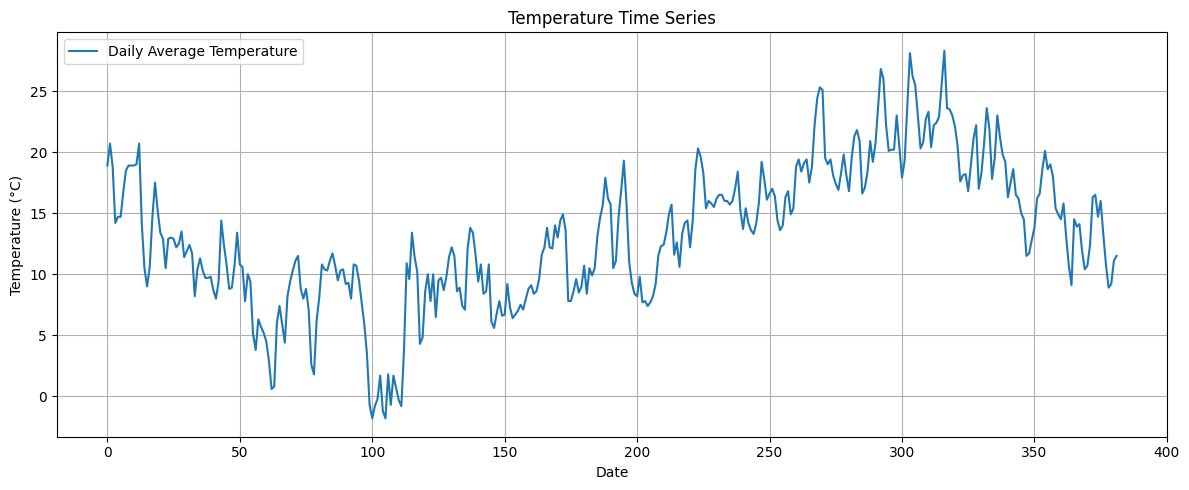

In [ ]:
# Select average temperature series
temp_series = df['temp']

plt.figure(figsize=(12, 5))
plt.plot(temp_series, label='Daily Average Temperature')
plt.title('Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ADF Testing
adf_result = adfuller(temp_series)
adf_output = {
    "ADF Statistic": adf_result[0],
    "p-value": adf_result[1],
    "Critical Values": adf_result[4],
}

adf_output

{'ADF Statistic': -2.74262288763004,
 'p-value': 0.06694856335880939,
 'Critical Values': {'1%': -3.4477686860685,
  '5%': -2.869216670067509,
  '10%': -2.570859500573892}}

Since p-value > 0.05 and ADF Statistic > critical value at 5%, the null hypothesis $H_0$ cannot be rejected.

-> Non-stationary series.

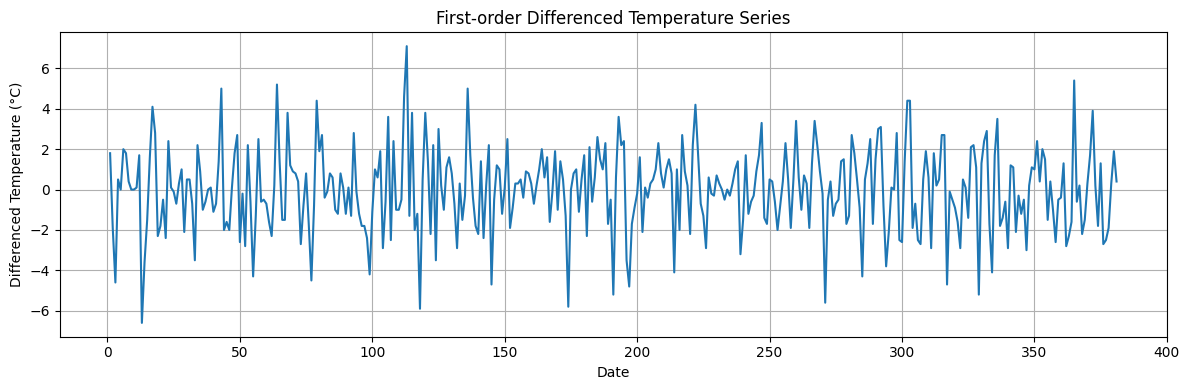

In [ ]:
# Take the first difference
temp_diff1 = temp_series.diff().dropna()

# Draw the first difference graph
plt.figure(figsize=(12, 4))
plt.plot(temp_diff1)
plt.title("First-order Differenced Temperature Series")
plt.xlabel("Date")
plt.ylabel("Differenced Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ADF verification after differentiation
adf_result_diff1 = adfuller(temp_diff1)

adf_output_diff1 = {
    "ADF Statistic": adf_result_diff1[0],
    "p-value": adf_result_diff1[1],
    "Critical Values": adf_result_diff1[4],

}

adf_output_diff1

{'ADF Statistic': -14.794239815296415,
 'p-value': 2.147810770410271e-27,
 'Critical Values': {'1%': -3.4477686860685,
  '5%': -2.869216670067509,
  '10%': -2.570859500573892}}

p-value < 0.05 and ADF Statistic < critical values ​​-> Reject the primary hypothesis $H_0$.

=> The first difference series is stationary.

## **5. PROPHET**

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df_prophet = df[['datetime', 'temp']].rename(columns={'datetime': 'ds', 'temp': 'y'})

In [ ]:
train_end_date = pd.to_datetime('2024-09-15')
train_df = df_prophet[df_prophet['ds'] <= train_end_date]
test_df = df_prophet[df_prophet['ds'] > train_end_date]

In [ ]:
model = Prophet(daily_seasonality=True)
model.fit(train_df)

10:56:41 - cmdstanpy - INFO - Chain [1] start processing
10:56:41 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

In [ ]:
forecast_test = forecast[forecast['ds'].isin(test_df['ds'])]

In [ ]:
rmse = np.sqrt(mean_squared_error(test_df['y'], forecast_test['yhat']))
r2 = r2_score(test_df['y'], forecast_test['yhat'])
mape = mean_absolute_percentage_error(test_df['y'], forecast_test['yhat'])

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}")

RMSE: 8.9119
R²: -7.3286
MAPE: 0.6739


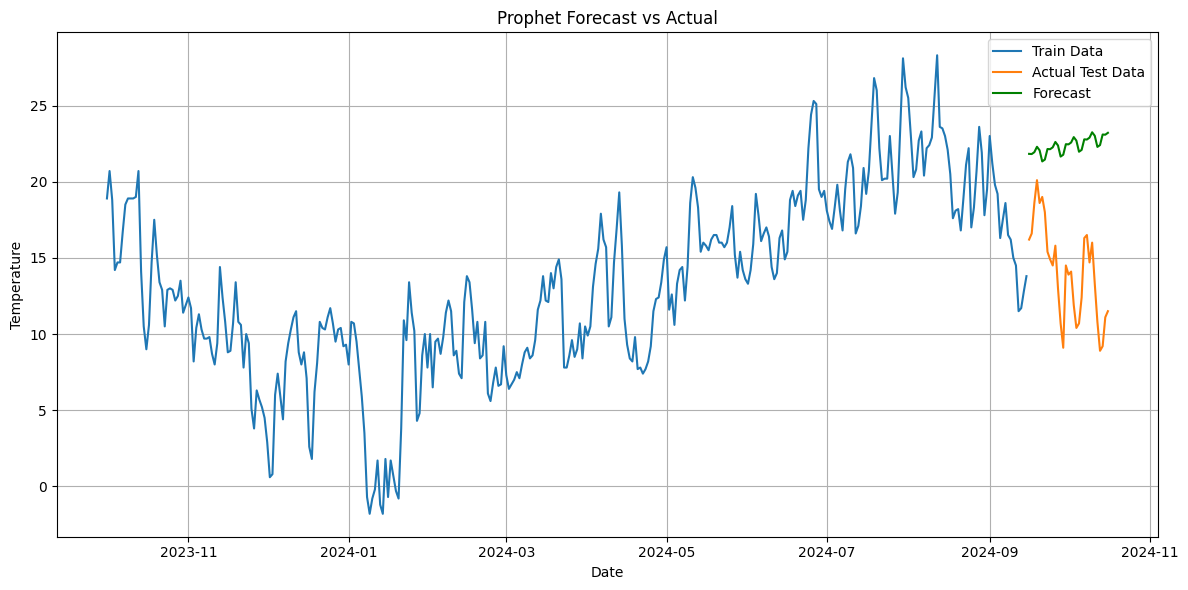

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Train Data')
plt.plot(test_df['ds'], test_df['y'], label='Actual Test Data')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Prophet Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- **RMSE: 8.9508°C**

  RMSE measures the average error between the predicted and actual temperatures in degrees Celsius. An RMSE of 8.9508°C means that, on average, the model’s predictions deviate from the actual temperature by nearly 9°C. For temperature forecasting in Paris, where daily temperatures typically range from 0°C to 25°C, this is a very high error. For context, an RMSE below 2°C is generally considered good for daily temperature forecasts, and even 3–4°C would be acceptable in some cases. An RMSE of 8.95°C indicates that the model’s predictions are often far off from the actual values, making it unreliable for practical use.

- **R²: -7.4015**

  R² measures how much of the variance in the actual temperature data is explained by the model, typically ranging from 0 to 1, where higher values indicate a better fit. However, R² can be negative when the model performs worse than a simple baseline. An R² of -7.4015 is extremely concerning—it means the model is not only failing to explain the variance in the temperature data but is performing far worse than a model that simply predicts the average temperature every day. In other words, the model’s predictions are so inaccurate that they introduce more error than if you ignored the model entirely and just used the historical average temperature.

- **MAPE: 0.6770**

  MAPE measures the average percentage error between the predicted and actual temperatures. A MAPE of 0.6770 (or 67.70%) means that, on average, the model’s predictions are off by 67.70% of the actual temperature. This is an extremely high error rate. For example, if the actual temperature is 20°C, the predicted temperature might be off by about 13.54°C (67.70% of 20°C), potentially predicting 6.46°C or 33.54°C—both of which are wildly inaccurate for Paris’s climate. In weather forecasting, a MAPE below 15% is typically acceptable, and a MAPE around 10% is considered good. A MAPE of 67.70% indicates that the model’s predictions are not just slightly off but are often completely detached from reality.

## **6. FEATURE ENGINEERING**

In [ ]:
# Convert datetime to right format
df['datetime'] = pd.to_datetime(df['datetime'])

# Split train, test
train_start = "2023-10-01"
train_end = "2024-09-15"
test_start = "2024-09-16"

df_train = df[(df['datetime'] >= train_start) & (df['datetime'] <= train_end)].copy()
df_test = df[(df['datetime'] >= test_start)].copy()

df_train_7 = df_train.copy()
df_test_7 = df_test.copy()

### **Interaction Features**

In [ ]:
def generate_interaction_features(df_train, df_test):
    train_copy = df_train.copy()
    test_copy = df_test.copy()

    pressure_mean = train_copy['sealevelpressure'].mean()
    pressure_std = train_copy['sealevelpressure'].std()
    def add_features(df, mean, std):
        # === HEAT INDEX RELATED FEATURES ===
        df["temp_humidity"] = df["temp"] * df["humidity"]
        df['feelslike_humidity'] = df['feelslike'] * df['humidity']

        # === WIND CHILL RELATED FEATURES ===
        df["temp_wind"] = df["temp"] * df["windspeed"]
        df['feelslike_winddir'] = df['feelslike'] * df['winddir']
        df["feelslike_diff"] = df["feelslike"] - df["temp"]

        # === WIND VECTOR COMPONENTS ===
        df["wind_x"] = df["windspeed"] * np.cos(np.deg2rad(df["winddir"]))
        df["wind_y"] = df["windspeed"] * np.sin(np.deg2rad(df["winddir"]))

        # === PRESSURE & HUMIDITY ===
        df["humidity_pressure"] = df["humidity"] * df["sealevelpressure"]

        # === TEMP & SOLAR ===
        df['temp_solar'] = df['temp'] * df['solarradiation']
        df['temp_uv'] = df['temp'] * df['uvindex']

        # === SOLAR & CLOUD ===
        df["solar_cloud_ratio"] = df["solarradiation"] / (df["cloudcover"] + 1)

        # === TEMPERATURE RANGE ===
        df["temp_range"] = df["tempmax"] - df["tempmin"]
        df["feelslike_range"] = df["feelslikemax"] - df["feelslikemin"]

        # === EFFECTIVE TEMPERATURE INDEX ===
        df['effective_temperature_index'] = (
            df["temp"]
            - 0.4 * (df["temp"] - 10) * (1 - df["humidity"]/100)
            + 0.16 * (df["windspeed"] - 1)
        )

        # === SOLAR RADIATION INDEX ===
        df['solar_radiation_index'] = df['solarradiation'] * (1 - df['cloudcover']/100)

        # === ATMOSPHERIC PRESSURE INDEX ===
        df['atmospheric_pressure_index'] = (
            (df['sealevelpressure'] - mean)
            / std
        )

        # === CLOUD COVER TEMPERATURE INDEX ===
        df['cloud_cover_temperature_index'] = df['temp'] * (1 - df['cloudcover']/100)

        return df

    train_with_features = add_features(train_copy, pressure_mean, pressure_std)
    test_with_features = add_features(test_copy, pressure_mean, pressure_std)

    print("Interaction features added successfully:")
    print(f"Train data shape: {train_with_features.shape}")
    print(f"Test data shape: {test_with_features.shape}")

    return train_with_features, test_with_features

df_train, df_test = generate_interaction_features(df_train, df_test)

Interaction features added successfully:
Train data shape: (351, 55)
Test data shape: (31, 55)


### **Rolling Window Features**

In [ ]:
def generate_rolling_features(df_train, df_test):
    train_copy = df_train.copy()
    test_copy = df_test.copy()

    def handle_rolling_nan(df, strategy='ffill'):
        df_copy = df.copy()
        rolling_features = [col for col in df.columns if any(suffix in col for suffix in ['_1', '_3', '_7', '_mean', '_std', '_min', '_max', '_diff'])]

        if strategy == 'ffill':
            df_copy[rolling_features] = df_copy[rolling_features].fillna(method='ffill')
        elif strategy == 'bfill':
            df_copy[rolling_features] = df_copy[rolling_features].fillna(method='bfill')
        elif strategy == 'interpolate':
            df_copy[rolling_features] = df_copy[rolling_features].interpolate(method='linear')
        elif strategy == 'zero':
            df_copy[rolling_features] = df_copy[rolling_features].fillna(0)
        elif strategy == 'mean':
            for col in rolling_features:
                df_copy[col] = df_copy[col].fillna(df_copy[col].mean())
        else:
            raise ValueError("Invalid strategy.")

        print("\nRemaining NaN values after handling:")
        remaining_nans = df_copy[rolling_features].isna().sum()
        print(remaining_nans[remaining_nans > 0])

        return df_copy

    def add_rolling_features(df):
        df = df.copy()
        numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

        cols_to_exclude = ['date', 'datetime', 'day_of_year', 'month', 'day_of_week',
                          'day_of_month', 'season_sin', 'season_cos']
        numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]

        rolling_windows = [3, 7, 14]

        target_col = 'temp' if 'temp' in numerical_cols else None

        for col in numerical_cols:
            # Lag features
            for lag in [1, 3, 7]:
                df[f"{col}_lag_{lag}"] = df[col].shift(lag)

            # Rolling features
            for window in rolling_windows:
                df[f"{col}_{window}d_mean"] = df[col].rolling(window=window, min_periods=1).mean()

                if window >= 7:
                    df[f"{col}_{window}d_std"] = df[col].rolling(window=window, min_periods=3).std()

                if col == target_col or 'pressure' in col or 'humidity' in col:
                    df[f"{col}_{window}d_min"] = df[col].rolling(window=window, min_periods=1).min()
                    df[f"{col}_{window}d_max"] = df[col].rolling(window=window, min_periods=1).max()

            # Exponential weighted mean
            for span in [3, 7]:
                df[f"{col}_ewm_{span}"] = df[col].ewm(span=span, min_periods=1).mean()

            # Diff
            df[f"{col}_1d_diff"] = df[col].diff(periods=1)
            df[f"{col}_3d_diff"] = df[col].diff(periods=3)

            # Momentum indicators
            df[f"{col}_momentum_3d"] = df[col] - df[col].shift(3)
            df[f"{col}_momentum_7d"] = df[col] - df[col].shift(7)

        return df

    train_with_features = add_rolling_features(train_copy)
    buffer_rows = train_copy.tail(14)
    test_buffered = pd.concat([buffer_rows, test_copy], ignore_index=True)
    test_with_buffer = add_rolling_features(test_buffered)
    test_with_features = test_with_buffer.iloc[14:].reset_index(drop=True)

    train_with_features = handle_rolling_nan(train_with_features, strategy='bfill')
    test_with_features = handle_rolling_nan(test_with_features, strategy='bfill')

    print("Rolling features added successfully:")
    print(f"Train data shape: {train_with_features.shape}")
    print(f"Test data shape: {test_with_features.shape}")
    print("\nExample of new rolling features:")
    print([col for col in train_with_features.columns if any(suffix in col for suffix in ['_mean', '_std', '_min', '_max', '_diff'])][:10])

    return train_with_features, test_with_features

df_train, df_test = generate_rolling_features(df_train, df_test)

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\658682874.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{window}d_std"] = df[col].rolling(window=window, min_periods=3).std()
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\658682874.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{window}d_mean"] = df[col].rolling(window=window, min_periods=1).mean()
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\658682874.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu


Remaining NaN values after handling:
Series([], dtype: int64)

Remaining NaN values after handling:
Series([], dtype: int64)
Rolling features added successfully:
Train data shape: (351, 671)
Test data shape: (31, 671)

Example of new rolling features:
['feelslike_diff', 'tempmax_3d_mean', 'tempmax_7d_mean', 'tempmax_7d_std', 'tempmax_14d_mean', 'tempmax_14d_std', 'tempmax_1d_diff', 'tempmax_3d_diff', 'tempmin_3d_mean', 'tempmin_7d_mean']


### **Trend, seasonality**

In [ ]:
def enrich_time_features(train_df, test_df):
    for df in [train_df, test_df]:
        # Month
        if 'month' not in df.columns:
            df['month'] = df['datetime'].dt.month

        # Period in a year (cyclical)
        df['day_of_year'] = df['datetime'].dt.dayofyear
        df['season_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
        df['season_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

        # Distance (in days) to the summer solstice (approx. day 172)
        solstice_day = 172
        df['solstice_distance'] = np.abs(df['day_of_year'] - solstice_day)

        # Cyclical features for month
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    print("Time features enriched/encoded.")
    print(f"Train data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")

    return train_df, test_df

df_train, df_test = enrich_time_features(df_train, df_test)

Time features enriched/encoded.
Train data shape: (351, 677)
Test data shape: (31, 677)


C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\866044359.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['day_of_year'] = df['datetime'].dt.dayofyear
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\866044359.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['season_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\866044359.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

### **Moonphase and Sunlight**

In [ ]:
def add_sun_and_moon_features(train_df, test_df):
    def process(df):
        # Moon features
        df["moonlight_intensity"] = np.sin(np.pi * df["moonphase"])
        df["moon_quarter"] = pd.cut(df["moonphase"], [-0.01, 0.25, 0.5, 0.75, 1.01],
                                    labels=["New Moon", "First Quarter", "Full Moon", "Last Quarter"])
        df["moon_phase_angle"] = 2 * np.pi * df["moonphase"]
        df["moon_cos"] = np.cos(df["moon_phase_angle"])
        df["moon_sin"] = np.sin(df["moon_phase_angle"])

        # Sunrise/sunset
        df["sunrise_dt"] = pd.to_datetime(df["sunrise"], format="%H:%M", errors="coerce")
        df["sunset_dt"] = pd.to_datetime(df["sunset"], format="%H:%M", errors="coerce")
        df["sunrise_mins"] = df["sunrise_dt"].dt.hour * 60 + df["sunrise_dt"].dt.minute
        df["sunset_mins"] = df["sunset_dt"].dt.hour * 60 + df["sunset_dt"].dt.minute
        df["daylight_duration"] = df["sunset_mins"] - df["sunrise_mins"]
        df["solar_noon"] = df["sunrise_mins"] + df["daylight_duration"] / 2
        df["light_ratio"] = df["daylight_duration"] / (24 * 60)
        df["solar_noon_deviation"] = np.abs(df["solar_noon"] - 12*60)

        # Date-based features
        df["day_of_year"] = df["datetime"].dt.dayofyear
        df["week_of_year"] = df["datetime"].dt.isocalendar().week.astype(int)

        df["season"] = ((df["day_of_year"] % 365) // 91).map({
            0: "Winter", 1: "Spring", 2: "Summer", 3: "Autumn", 4: "Winter"
        })
        df["season_encoded"] = df["season"].map({"Winter": 0, "Spring": 1, "Summer": 2, "Autumn": 3})

        # Delete unecessary columns
        df.drop(columns=["sunrise_dt", "sunset_dt", "season"], inplace=True)
        return df

    train_df = process(train_df.copy())
    test_df = process(test_df.copy())

    max_daylight = train_df["daylight_duration"].max()
    train_df["normalized_daylight"] = train_df["daylight_duration"] / max_daylight
    test_df["normalized_daylight"] = test_df["daylight_duration"] / max_daylight

    return train_df, test_df

df_train, df_test = add_sun_and_moon_features(df_train, df_test)

### **Categorical Features**

In [ ]:
for df in [df_train, df_test]:
    if 'day' in df.columns:
        df.rename(columns={'day': 'original_day'}, inplace=True)
    if 'snow' in df.columns:
        df.rename(columns={'snow': 'original_snow'}, inplace=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def process_object_and_category(train_df, test_df):
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Preciptype to binary
    for df in [train_df, test_df]:
        df['preciptype'] = df['preciptype'].fillna('no precipitation')
        labels = ['no precipitation', 'rain', 'snow', 'freezingrain']
        for label in labels:
            df[f'precip_{label.replace(" ", "_")}'] = df['preciptype'].str.contains(label).astype(int)

    # Conditions to score
    condition_weights = {
        'Clear': 2.0,
        'Partially cloudy': 1.0,
        'Overcast': -1.0,
        'Rain': -2.0,
        'Snow': -3.0,
        'Freezing Drizzle/Freezing Rain': -2.5
    }

    def compute_condition_score(conditions_str):
        if pd.isna(conditions_str):
            return 0
        score = 0
        for condition, weight in condition_weights.items():
            if condition in conditions_str:
                score += weight
        return score

    for df in [train_df, test_df]:
        df['condition_temp_score'] = df['new_conditions'].apply(compute_condition_score)

    # 3. TF-IDF for description
    tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_train = tfidf.fit_transform(train_df['description'].fillna(''))
    tfidf_test = tfidf.transform(test_df['description'].fillna(''))

    tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf.get_feature_names_out(), index=train_df.index)
    tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names_out(), index=test_df.index)

    train_df = pd.concat([train_df.reset_index(drop=True), tfidf_train_df.reset_index(drop=True)], axis=1)
    test_df = pd.concat([test_df.reset_index(drop=True), tfidf_test_df.reset_index(drop=True)], axis=1)

    # One-hot encoding for 'icon'
    all_icons = pd.concat([train_df['icon'], test_df['icon']]).astype('category')
    all_icons = all_icons.cat.categories

    for df in [train_df, test_df]:
        df['icon'] = pd.Categorical(df['icon'], categories=all_icons)
        icon_dummies = pd.get_dummies(df['icon'], prefix='icon').astype(int)  # ép kiểu ở đây
        df.drop('icon', axis=1, inplace=True)
        df[icon_dummies.columns] = icon_dummies

    # One-hot encoding for 'moon_quarter'
    all_moons = pd.concat([train_df['moon_quarter'], test_df['moon_quarter']]).astype('category')
    all_moons = all_moons.cat.categories

    for df in [train_df, test_df]:
        df['moon_quarter'] = pd.Categorical(df['moon_quarter'], categories=all_moons)
        moon_dummies = pd.get_dummies(df['moon_quarter'], prefix='moon_quarter').astype(int)  # ép kiểu ở đây
        df.drop('moon_quarter', axis=1, inplace=True)
        df[moon_dummies.columns] = moon_dummies


    return train_df, test_df

df_train, df_test = process_object_and_category(df_train, df_test)

In [ ]:
cols_to_drop = ['name', 'preciptype', 'conditions', 'description', 'stations', 'new_conditions', 'sunrise', 'sunset']

df_train.drop(columns=cols_to_drop, inplace=True, errors='ignore')
df_test.drop(columns=cols_to_drop, inplace=True, errors='ignore')

for df_ in [df_train, df_test]:
    df_['datetime'] = pd.to_datetime(df_['datetime'])
    df_.set_index('datetime', inplace=True)

# Check index of df_test
print("df_test index range:", df_test.index.min(), "->", df_test.index.max())
print("df_test shape:", df_test.shape)

df_test index range: 2024-09-16 00:00:00 -> 2024-10-16 00:00:00
df_test shape: (31, 708)


### **Multicolinearity**

In [ ]:
print("Checking and Removing Multicollinearity")

# Identify Feature Columns (excluding 'temp')
target_col = 'temp'
if target_col in df_train.columns:
    feature_cols = df_train.columns.drop(target_col)
else:
    print(f"Warning: Target column '{target_col}' not found in df_train. Using all columns.")
    feature_cols = df_train.columns

# Select only numerical columns for correlation calculation
numerical_feature_cols = df_train[feature_cols].select_dtypes(include=np.number).columns
print(f"Number of numerical features considered: {len(numerical_feature_cols)}")

# Compute Correlation Matrix on df_train
corr_matrix = df_train[numerical_feature_cols].corr()

# Identify Highly Correlated Pairs
correlation_threshold = 0.95
print(f"Correlation threshold for removal: {correlation_threshold}")

# Get the upper triangle of the correlation matrix (excluding diagonal)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs with absolute correlation > threshold
highly_correlated_pairs = [
    (column, index) for column in upper_tri.columns for index in upper_tri.index
    if abs(upper_tri.loc[index, column]) > correlation_threshold
]

print(f"\nFound {len(highly_correlated_pairs)} feature pairs with correlation > {correlation_threshold}:")

# Decide Which Columns to Remove
cols_to_drop_multi = set()

if highly_correlated_pairs:
    # Compute mean absolute correlation for each feature
    mean_abs_corr = abs(corr_matrix).mean(axis=1)

    print("\nDeciding columns to remove based on mean absolute correlation:")
    for col1, col2 in highly_correlated_pairs:
        # Skip if either column is already marked for removal
        if col1 in cols_to_drop_multi or col2 in cols_to_drop_multi:
            continue

        mean_corr1 = mean_abs_corr.get(col1, 0)
        mean_corr2 = mean_abs_corr.get(col2, 0)

        if mean_corr1 > mean_corr2:
            col_to_remove = col1
            print(f"- Between '{col1}' ({mean_corr1:.3f}) and '{col2}' ({mean_corr2:.3f}), removing '{col_to_remove}' (higher mean correlation)")
            cols_to_drop_multi.add(col_to_remove)
        else:
            col_to_remove = col2
            print(f"- Between '{col1}' ({mean_corr1:.3f}) and '{col2}' ({mean_corr2:.3f}), removing '{col_to_remove}' (higher or equal mean correlation)")
            cols_to_drop_multi.add(col_to_remove)
else:
    print("\nNo feature pairs exceed the correlation threshold for removal.")

# Drop Columns from df_train and df_test
cols_to_drop_multi_list = list(cols_to_drop_multi)
if cols_to_drop_multi_list:
    print(f"\nColumns to be removed due to multicollinearity: {cols_to_drop_multi_list}")

    # Store initial column count
    train_cols_before = df_train.shape[1]
    test_cols_before = df_test.shape[1]

    # Perform column removal
    df_train.drop(columns=cols_to_drop_multi_list, inplace=True, errors='ignore')
    df_test.drop(columns=cols_to_drop_multi_list, inplace=True, errors='ignore')

    print(f"\nRemoved {len(cols_to_drop_multi_list)} columns.")
    print(f"df_train shape: {train_cols_before} columns -> {df_train.shape[1]} columns")
    print(f"df_test shape: {test_cols_before} columns -> {df_test.shape[1]} columns")
else:
    print("\nNo columns removed due to multicollinearity.")

print("\nMulticollinearity Check Completed")

Checking and Removing Multicollinearity
Number of numerical features considered: 707
Correlation threshold for removal: 0.95

Found 1384 feature pairs with correlation > 0.95:

Deciding columns to remove based on mean absolute correlation:
- Between 'feelslikemax' (0.400) and 'tempmax' (0.403), removing 'tempmax' (higher or equal mean correlation)
- Between 'feelslikemin' (0.374) and 'tempmin' (0.372), removing 'feelslikemin' (higher mean correlation)
- Between 'feelslike' (0.393) and 'tempmin' (0.372), removing 'feelslike' (higher mean correlation)
- Between 'dew' (0.347) and 'tempmin' (0.372), removing 'tempmin' (higher or equal mean correlation)
- Between 'solarenergy' (0.347) and 'solarradiation' (0.347), removing 'solarenergy' (higher mean correlation)
- Between 'temp_humidity' (0.357) and 'dew' (0.347), removing 'temp_humidity' (higher mean correlation)
- Between 'feelslike_humidity' (0.358) and 'dew' (0.347), removing 'feelslike_humidity' (higher mean correlation)
- Between 'hum

Choosing to use the correlation matrix to handle multicollinearity, even though it only captures pairwise correlations and does not generalize to more complex multicollinearity patterns like VIF. This decision is made because VIF is too slow and not suitable for the large number of features in the current dataset.

In [ ]:
target_col = 'temp'
lag_days = (df_test.index.max() - df_train.index.max()).days

# Train set
X_train = df_train.drop(columns=[target_col]).shift(lag_days)
y_train = df_train[target_col]
X_train = X_train.iloc[lag_days:].reset_index(drop=True)
y_train = y_train.iloc[lag_days:].reset_index(drop=True)

# Test set - Modify as required
# Get data lagged by 31 days (e.g., using data from 20/08/2024 for predicting 20/09/2024)
X_test_lagged = df_train.drop(columns=[target_col]).iloc[-lag_days:].reset_index(drop=True)

# Get the last day of the train set (15/09/2024)
last_day_train = df_train.drop(columns=[target_col]).iloc[-1]

# Create a DataFrame by copying X_test_lagged and assigning values
last_day_repeated = X_test_lagged.copy()
for col in last_day_repeated.columns:
    last_day_repeated[col] = last_day_train[col]

# Apply weighted averaging
alpha = 0.4  # Smoothing factor, closer to 1 means closer to last_day values
X_test = (X_test_lagged * (1 - alpha)) + (last_day_train * alpha)

# True labels: First 30 days of df_test
y_test = df_test[target_col].iloc[:lag_days].reset_index(drop=True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def get_important_features(X, y, threshold=0.0001):
    # Train a Random Forest model
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X, y)

    # Get feature importances
    feature_importances = rf.feature_importances_

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Filter features with importance above the threshold
    important_features = importance_df[importance_df["Importance"] > threshold]
    selected_features = important_features["Feature"].tolist()

    print(f"Selected {len(selected_features)} important features out of {X.shape[1]}")

    return selected_features

def process_and_select_features(X_train, y_train, X_test=None, threshold=0.0001):
    if y_train is not None:
        # Get important features
        important_features = get_important_features(X_train, y_train, threshold=threshold)

        # Filter training dataset
        X_train_reduced = X_train[important_features]
        print(f"Reduced training dataset shape: {X_train_reduced.shape}")

        # If test set is provided, filter it using the same important features
        if X_test is not None:
            X_test_reduced = X_test[important_features]
            print(f"Reduced test dataset shape: {X_test_reduced.shape}")
            return X_train_reduced, X_test_reduced, y_train

        return X_train_reduced, None, y_train
    else:
        print("Target column 'y_train' not found or is None.")
        return X_train, X_test, None

X_train_reduced, X_test_reduced, y_train_rf = process_and_select_features(X_train, y_train, X_test=X_test, threshold=0.0001)  # RF

Selected 339 important features out of 433
Reduced training dataset shape: (320, 339)
Reduced test dataset shape: (31, 339)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

model = RandomForestRegressor(random_state=42, n_estimators=50)

# Fit on train
model.fit(X_train_reduced, y_train_rf)

# Predict on train
y_train_pred = model.predict(X_train_reduced)

# Predict on test
y_test_pred = model.predict(X_test_reduced)

# Metrics for train
rmse_train = np.sqrt(mean_squared_error(y_train_rf, y_train_pred))
r2_train = r2_score(y_train_rf, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train_rf, y_train_pred)

# Metrics for test
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

# Result
print("Evaluation for Randomforest:")
print(f"Train RMSE: {rmse_train:.3f} | Test RMSE: {rmse_test:.3f}")
print(f"Train R² Score: {r2_train:.3f} | Test R² Score: {r2_test:.3f}")
print(f"Train MAPE: {mape_train:.3%} | Test MAPE: {mape_test:.3%}")

Evaluation for Randomforest:
Train RMSE: 0.849 | Test RMSE: 2.331
Train R² Score: 0.981 | Test R² Score: 0.430
Train MAPE: 12.111% | Test MAPE: 13.439%


In [ ]:
import optuna
import json
import os

# File name for saving best RF parameters
BEST_RF_PARAMS_FILE = "best_rf_params.json"

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return rmse, r2, mape

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000, step=50)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.05, 1.0)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    rmse, _, _ = evaluate_model(model, X_test, y_test)
    return rmse

study = optuna.create_study(direction='minimize', study_name="rf_experiment")
study.optimize(objective, n_trials=50)

# Get best parameters from this run
new_best_params = study.best_params
print("Optimization results for this run:", new_best_params)

# Read best parameters from previous runs
if os.path.exists(BEST_RF_PARAMS_FILE):
    with open(BEST_RF_PARAMS_FILE, "r") as f:
        saved_best_params = json.load(f)
        print("Best parameters from previous runs:", saved_best_params)
else:
    saved_best_params = None

# Compare models
print("\nRetraining the model for comparison...")

# Train new model
new_model = RandomForestRegressor(**new_best_params, random_state=42, n_jobs=-1)
new_model.fit(X_train_reduced, y_train_rf)
new_rmse, new_r2, new_mape = evaluate_model(new_model, X_test_reduced, y_test)

# Train old model if available
if saved_best_params:
    old_model = RandomForestRegressor(**saved_best_params, random_state=42, n_jobs=-1)
    old_model.fit(X_train_reduced, y_train_rf)
    old_rmse, old_r2, old_mape = evaluate_model(old_model, X_test_reduced, y_test)

    print("\nModel comparison:")
    print(f"New model:   RMSE = {new_rmse:.3f}, R² = {new_r2:.3f}, MAPE = {new_mape:.3%}")
    print(f"Previous model:   RMSE = {old_rmse:.3f}, R² = {old_r2:.3f}, MAPE = {old_mape:.3%}")

    # If the new model is better (lower RMSE), update the best parameters
    if new_rmse < old_rmse:
        print("New model is BETTER! Updating best parameters.")
        with open(BEST_RF_PARAMS_FILE, "w") as f:
            json.dump(new_best_params, f)
    else:
        print("Previous model is still better. Keeping old parameters.")
else:
    print(f"No previous model found. Saving new best parameters!")
    with open(BEST_RF_PARAMS_FILE, "w") as f:
        json.dump(new_best_params, f)

print("\nProcess completed!")

[I 2025-04-02 10:56:49,650] A new study created in memory with name: rf_experiment
[I 2025-04-02 10:56:50,626] Trial 0 finished with value: 2.300062650196322 and parameters: {'n_estimators': 1000, 'max_depth': 26, 'min_samples_split': 33, 'min_samples_leaf': 12, 'max_features': 0.38217967137156417}. Best is trial 0 with value: 2.300062650196322.
[I 2025-04-02 10:56:51,487] Trial 1 finished with value: 2.105126761457516 and parameters: {'n_estimators': 850, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 20, 'max_features': 0.5245949160414098}. Best is trial 1 with value: 2.105126761457516.
[I 2025-04-02 10:56:51,923] Trial 2 finished with value: 2.5087069268789475 and parameters: {'n_estimators': 150, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 0.9914652896817464}. Best is trial 1 with value: 2.105126761457516.
[I 2025-04-02 10:56:52,475] Trial 3 finished with value: 2.2362092998270757 and parameters: {'n_estimators': 550, 'max_depth': 

Optimization results for this run: {'n_estimators': 50, 'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 0.5615970065263723}
Best parameters from previous runs: {'n_estimators': 350, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.6692818488005166}

Retraining the model for comparison...

Model comparison:
New model:   RMSE = 2.105, R² = 0.535, MAPE = 14.106%
Previous model:   RMSE = 1.941, R² = 0.605, MAPE = 12.781%
Previous model is still better. Keeping old parameters.

Process completed!


Loaded best parameters: {'n_estimators': 350, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.6692818488005166}


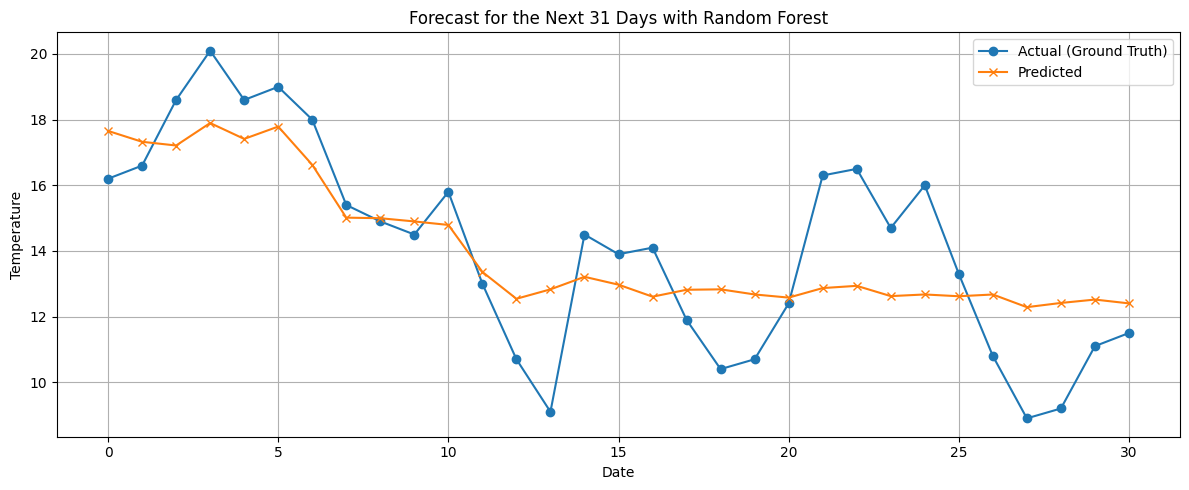

In [ ]:
# Check if the parameter file exists
if not os.path.exists(BEST_RF_PARAMS_FILE):
    print("No optimal parameters found! Please run Optuna first.")
    exit()

# Load the best parameters from the file
with open(BEST_RF_PARAMS_FILE, "r") as f:
    best_params = json.load(f)
    print(f"Loaded best parameters: {best_params}")

# Initialize the model with the saved parameters
best_model_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_model_rf.fit(X_train_reduced, y_train_rf)

# Make predictions on the test set
y_pred = best_model_rf.predict(X_test_reduced)

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual (Ground Truth)', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("Forecast for the Next 31 Days with Random Forest")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import lightgbm as lgb

def get_important_features_lgbm(X, y, threshold=0.0001):
    # Train a LightGBM model
    lgbm = lgb.LGBMRegressor(random_state=42)
    lgbm.fit(X, y)

    # Get feature importances from the model
    feature_importances = lgbm.feature_importances_

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Filter features with importance above the threshold
    important_features = importance_df[importance_df["Importance"] > threshold]
    selected_features = important_features["Feature"].tolist()

    print(f"Selected {len(selected_features)} important features out of {X.shape[1]}")

    return selected_features

def process_and_select_features_lgbm(X_train, y_train, X_test=None, threshold=0.0001):
    if y_train is not None:
        # Get important features using LightGBM
        important_features = get_important_features_lgbm(X_train, y_train, threshold=threshold)

        # Filter training dataset
        X_train_reduced = X_train[important_features]
        print(f"Reduced training dataset shape: {X_train_reduced.shape}")

        # If test set is provided, filter it using the same important features
        if X_test is not None:
            X_test_reduced = X_test[important_features]
            print(f"Reduced test dataset shape: {X_test_reduced.shape}")
            return X_train_reduced, X_test_reduced, y_train

        return X_train_reduced, None, y_train
    else:
        print("Target column 'y_train' not found or is None.")
        return X_train, X_test, None

X_train_reduced_gbm, X_test_reduced_gbm, y_train_gbm = process_and_select_features_lgbm(X_train, y_train, X_test=X_test, threshold=0.0001)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33690
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 402
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [ ]:
model = lgb.LGBMRegressor(random_state=42, n_estimators=30)

# Fit for train
model.fit(X_train_reduced_gbm, y_train_gbm)

# Predict for train
y_train_pred = model.predict(X_train_reduced_gbm)

# Predict for test
y_test_pred = model.predict(X_test_reduced_gbm)

# Metrics for train
rmse_train = np.sqrt(mean_squared_error(y_train_gbm, y_train_pred))
r2_train = r2_score(y_train_gbm, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train_gbm, y_train_pred)

# Metrics for test
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

# result
print("Evaluatetion for LightGBM:")
print(f"Train RMSE: {rmse_train:.3f} | Test RMSE: {rmse_test:.3f}")
print(f"Train R² Score: {r2_train:.3f} | Test R² Score: {r2_test:.3f}")
print(f"Train MAPE: {mape_train:.3%} | Test MAPE: {mape_test:.3%}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [ ]:
# File name for saving best LGB parameters
BEST_LGBM_PARAMS_FILE = "best_lgbm_params.json"

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return rmse, r2, mape

def objective(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 10, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=50),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 50),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 10),
    }

    model = lgb.LGBMRegressor(**params, random_state=42, n_jobs=-1)
    model.fit(X_train_reduced_gbm, y_train_gbm)

    rmse, _, _ = evaluate_model(model, X_test_reduced_gbm, y_test)
    return rmse

study = optuna.create_study(direction="minimize", study_name="lgbm_experiment")
study.optimize(objective, n_trials=50)

# Get best parameters from this run
new_best_params = study.best_params
print("Optimization results for this run:", new_best_params)

# Read best parameters from previous runs
if os.path.exists(BEST_LGBM_PARAMS_FILE):
    with open(BEST_LGBM_PARAMS_FILE, "r") as f:
        saved_best_params = json.load(f)
        print("Best parameters from previous runs:", saved_best_params)
else:
    saved_best_params = None

# Compare models
print("\nRetraining the model for comparison...")

# Train new model
new_model = lgb.LGBMRegressor(**new_best_params, random_state=42, n_jobs=-1)
new_model.fit(X_train_reduced_gbm, y_train_gbm)
new_rmse, new_r2, new_mape = evaluate_model(new_model, X_test_reduced_gbm, y_test)

# Train old model if available
if saved_best_params:
    old_model = lgb.LGBMRegressor(**saved_best_params, random_state=42, n_jobs=-1)
    old_model.fit(X_train_reduced_gbm, y_train_gbm)
    old_rmse, old_r2, old_mape = evaluate_model(old_model, X_test_reduced_gbm, y_test)

    print("\nModel comparison:")
    print(f"New model:   RMSE = {new_rmse:.3f}, R² = {new_r2:.3f}, MAPE = {new_mape:.3%}")
    print(f"Previous model:   RMSE = {old_rmse:.3f}, R² = {old_r2:.3f}, MAPE = {old_mape:.3%}")

    # If the new model is better (lower RMSE), update the best parameters
    if new_rmse < old_rmse:
        print("New model is BETTER! Updating best parameters.")
        with open(BEST_LGBM_PARAMS_FILE, "w") as f:
            json.dump(new_best_params, f)
    else:
        print("Previous model is still better. Keeping old parameters.")
else:
    print(f"No previous model found. Saving new best parameters!")
    with open(BEST_LGBM_PARAMS_FILE, "w") as f:
        json.dump(new_best_params, f)

print("\nProcess completed!")

[I 2025-04-02 10:57:32,327] A new study created in memory with name: lgbm_experiment


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:32,967] Trial 0 finished with value: 2.430921654314865 and parameters: {'num_leaves': 329, 'max_depth': 46, 'learning_rate': 0.005258509015468396, 'n_estimators': 550, 'min_child_samples': 24, 'subsample': 0.7876775683145062, 'colsample_bytree': 0.8737660296951625, 'reg_alpha': 1.7443544092996608e-05, 'reg_lambda': 0.5760651511969495}. Best is trial 0 with value: 2.430921654314865.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:33,537] Trial 1 finished with value: 2.223412902873879 and parameters: {'num_leaves': 216, 'max_depth': 4, 'learning_rate': 0.008542075594448488, 'n_estimators': 450, 'min_child_samples': 10, 'subsample': 0.33442694227145087, 'colsample_bytree': 0.9391881611253191, 'reg_alpha': 0.018815857585459426, 'reg_lambda': 1.2597037621827762e-05}. Best is trial 1 with value: 2.223412902873879.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:35,662] Trial 2 finished with value: 2.1306143718103314 and parameters: {'num_leaves': 448, 'max_depth': 20, 'learning_rate': 0.08963946526491978, 'n_estimators': 750, 'min_child_samples': 2, 'subsample': 0.7665893987670817, 'colsample_bytree': 0.8655628845144406, 'reg_alpha': 0.00011646632900967619, 'reg_lambda': 0.014255693210353321}. Best is trial 2 with value: 2.1306143718103314.
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:36,454] Trial 3 finished with value: 2.5645725657758316 and parameters: {'num_leaves': 292, 'max_depth': 19, 'learning_rate': 0.03923823899440122, 'n_estimators': 200, 'min_child_samples': 7, 'subsample': 0.3549236445107995, 'colsample_bytree': 0.9285180525651174, 'reg_alpha': 6.531726277962752e-05, 'reg_lambda': 0.004836577489042024}. Best is trial 2 with value: 2.1306143718103314.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:36,850] Trial 4 finished with value: 2.717391002643151 and parameters: {'num_leaves': 466, 'max_depth': 21, 'learning_rate': 0.001787407314479884, 'n_estimators': 650, 'min_child_samples': 43, 'subsample': 0.11955670181327122, 'colsample_bytree': 0.8787431479247563, 'reg_alpha': 1.1485935064739552, 'reg_lambda': 1.278365050553484}. Best is trial 2 with value: 2.1306143718103314.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:37,581] Trial 6 finished with value: 2.3878590008381066 and parameters: {'num_leaves': 323, 'max_depth': 40, 'learning_rate': 0.012436201907659135, 'n_estimators': 800, 'min_child_samples': 27, 'subsample': 0.2335375719364836, 'colsample_bytree': 0.6003981499568525, 'reg_alpha': 0.07084229027102586, 'reg_lambda': 2.3409309220097718e-05}. Best is trial 2 with value: 2.1306143718103314.
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:37,850] Trial 7 finished with value: 2.65945697558043 and parameters: {'num_leaves': 377, 'max_depth': 42, 'learning_rate': 0.0014892755434391728, 'n_estimators': 550, 'min_child_samples': 30, 'subsample': 0.7173787393780329, 'colsample_bytree': 0.27295254240831834, 'reg_alpha': 3.440606352437247e-05, 'reg_lambda': 0.21341194184470375}. Best is trial 2 with value: 2.1306143718103314.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:38,743] Trial 10 finished with value: 2.909900167697458 and parameters: {'num_leaves': 493, 'max_depth': 10, 'learning_rate': 0.32338875445109555, 'n_estimators': 850, 'min_child_samples': 16, 'subsample': 0.9901266590111135, 'colsample_bytree': 0.47304525399840497, 'reg_alpha': 0.0014484377997122707, 'reg_lambda': 0.0009536632031563057}. Best is trial 2 with value: 2.1306143718103314.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:39,125] Trial 11 finished with value: 2.5848540571555847 and parameters: {'num_leaves': 175, 'max_depth': 2, 'learning_rate': 0.24352119976029446, 'n_estimators': 1000, 'min_child_samples': 11, 'subsample': 0.40478689179765714, 'colsample_bytree': 0.9897259799266312, 'reg_alpha': 0.017711381447840194, 'reg_lambda': 0.00036566142863016856}. Best is trial 2 with value: 2.1306143718103314.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:41,476] Trial 12 finished with value: 2.0099180183629906 and parameters: {'num_leaves': 205, 'max_depth': 11, 'learning_rate': 0.012409911725467845, 'n_estimators': 300, 'min_child_samples': 2, 'subsample': 0.9099899471685935, 'colsample_bytree': 0.6646472156007974, 'reg_alpha': 0.0017767468363762162, 'reg_lambda': 0.06117917183247765}. Best is trial 12 with value: 2.0099180183629906.
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:42,458] Trial 13 finished with value: 2.510168522183907 and parameters: {'num_leaves': 94, 'max_depth': 15, 'learning_rate': 0.098225730352837, 'n_estimators': 300, 'min_child_samples': 1, 'subsample': 0.9694286975326053, 'colsample_bytree': 0.6255757256035532, 'reg_alpha': 0.0011095098266309586, 'reg_lambda': 0.059989473066524523}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:42,798] Trial 14 finished with value: 2.3767056399083235 and parameters: {'num_leaves': 245, 'max_depth': 27, 'learning_rate': 0.01758864705239912, 'n_estimators': 300, 'min_child_samples': 18, 'subsample': 0.8359550098591686, 'colsample_bytree': 0.44550537683614083, 'reg_alpha': 0.0008942818910667212, 'reg_lambda': 5.953941340085964}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:43,230] Trial 15 finished with value: 2.6893468769506934 and parameters: {'num_leaves': 424, 'max_depth': 10, 'learning_rate': 0.14913812859137843, 'n_estimators': 750, 'min_child_samples': 37, 'subsample': 0.8583684927417111, 'colsample_bytree': 0.71186977696951, 'reg_alpha': 0.17869920219255594, 'reg_lambda': 0.02487221784870971}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:46,939] Trial 16 finished with value: 2.051066317654671 and parameters: {'num_leaves': 172, 'max_depth': 28, 'learning_rate': 0.028402878489896047, 'n_estimators': 1000, 'min_child_samples': 1, 'subsample': 0.6806598733870426, 'colsample_bytree': 0.670248456933169, 'reg_alpha': 0.0042011143681357326, 'reg_lambda': 0.0019080979829807975}. Best is trial 12 with value: 2.0099180183629906.
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:48,160] Trial 17 finished with value: 2.3117284224057455 and parameters: {'num_leaves': 100, 'max_depth': 30, 'learning_rate': 0.02410455360369213, 'n_estimators': 1000, 'min_child_samples': 13, 'subsample': 0.66932629332426, 'colsample_bytree': 0.43771571271937293, 'reg_alpha': 0.004136224447206206, 'reg_lambda': 0.00020157106733619253}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Au

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:48,778] Trial 18 finished with value: 2.6743043835229616 and parameters: {'num_leaves': 180, 'max_depth': 34, 'learning_rate': 0.00533259526745213, 'n_estimators': 400, 'min_child_samples': 7, 'subsample': 0.4861277897270323, 'colsample_bytree': 0.1055947511766302, 'reg_alpha': 0.004858313364360707, 'reg_lambda': 0.0019513703969025907}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:49,825] Trial 20 finished with value: 2.2435508280219203 and parameters: {'num_leaves': 167, 'max_depth': 12, 'learning_rate': 0.004756899802811756, 'n_estimators': 900, 'min_child_samples': 19, 'subsample': 0.6654191200946445, 'colsample_bytree': 0.5256617960524501, 'reg_alpha': 0.0003922444479785268, 'reg_lambda': 0.00015060989352241581}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:51,633] Trial 21 finished with value: 2.0571459128556318 and parameters: {'num_leaves': 263, 'max_depth': 21, 'learning_rate': 0.08675978482985958, 'n_estimators': 700, 'min_child_samples': 1, 'subsample': 0.7506136516008577, 'colsample_bytree': 0.8060607591540041, 'reg_alpha': 0.0003248789360703615, 'reg_lambda': 0.01737547364828505}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:53,946] Trial 22 finished with value: 2.1418587356565917 and parameters: {'num_leaves': 255, 'max_depth': 16, 'learning_rate': 0.012662502566475557, 'n_estimators': 650, 'min_child_samples': 6, 'subsample': 0.8983654456860344, 'colsample_bytree': 0.7766546874327874, 'reg_alpha': 0.0036635757746057186, 'reg_lambda': 0.06884772711968064}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:54,825] Trial 23 finished with value: 2.494721175217624 and parameters: {'num_leaves': 225, 'max_depth': 24, 'learning_rate': 0.1443414952465284, 'n_estimators': 900, 'min_child_samples': 1, 'subsample': 0.49490456262586, 'colsample_bytree': 0.5681017822927854, 'reg_alpha': 0.0003986436141753115, 'reg_lambda': 0.0027753470963563284}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:55,430] Trial 24 finished with value: 2.2545767287292944 and parameters: {'num_leaves': 282, 'max_depth': 6, 'learning_rate': 0.0640106819013521, 'n_estimators': 650, 'min_child_samples': 6, 'subsample': 0.7283287085244534, 'colsample_bytree': 0.7002255461732105, 'reg_alpha': 0.014587462283030912, 'reg_lambda': 0.035705182391367156}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:55,885] Trial 25 finished with value: 2.429723386940659 and parameters: {'num_leaves': 130, 'max_depth': 35, 'learning_rate': 0.02638711350916647, 'n_estimators': 350, 'min_child_samples': 14, 'subsample': 0.670559903026969, 'colsample_bytree': 0.801554428317875, 'reg_alpha': 0.000395533536701992, 'reg_lambda': 0.0058844992295476115}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:56,345] Trial 26 finished with value: 2.0126569606449296 and parameters: {'num_leaves': 205, 'max_depth': 24, 'learning_rate': 0.009184879855026027, 'n_estimators': 200, 'min_child_samples': 9, 'subsample': 0.9315509702689806, 'colsample_bytree': 0.6548828779524054, 'reg_alpha': 0.002027601827455734, 'reg_lambda': 0.0012471884625573281}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:56,628] Trial 27 finished with value: 2.3793224564035906 and parameters: {'num_leaves': 203, 'max_depth': 30, 'learning_rate': 0.00884941935755701, 'n_estimators': 200, 'min_child_samples': 11, 'subsample': 0.948481176035241, 'colsample_bytree': 0.38106005696509015, 'reg_alpha': 0.043593936712400805, 'reg_lambda': 0.0007629307706704158}. Best is trial 12 with value: 2.0099180183629906.
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:57,118] Trial 28 finished with value: 2.6830780627193658 and parameters: {'num_leaves': 73, 'max_depth': 37, 'learning_rate': 0.003114489479876425, 'n_estimators': 150, 'min_child_samples': 5, 'subsample': 0.8270072808931944, 'colsample_bytree': 0.5258831601701666, 'reg_alpha': 0.3025149723125286, 'reg_lambda': 9.086561969750111e-05}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:57:57,699] Trial 29 finished with value: 2.0694207685790014 and parameters: {'num_leaves': 145, 'max_depth': 50, 'learning_rate': 0.005794931699945027, 'n_estimators': 300, 'min_child_samples': 9, 'subsample': 0.9190449725084329, 'colsample_bytree': 0.6344947308760615, 'reg_alpha': 0.002327797415517284, 'reg_lambda': 0.0011013240321785381}. Best is trial 12 with value: 2.0099180183629906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:57:59,129] Trial 30 finished with value: 2.206342493369038 and parameters: {'num_leaves': 51, 'max_depth': 16, 'learning_rate': 0.010487660562591674, 'n_estimators': 450, 'min_child_samples': 4, 'subsample': 0.8080358513838342, 'colsample_bytree': 0.7127233742957736, 'reg_alpha': 1.5039945054891914e-05, 'reg_lambda': 1.192869187855446}. Best is trial 12 with value: 2.0099180183629906.
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:58:04,181] Trial 31 finished with value: 2.2196066876547764 and parameters: {'num_leaves': 285, 'max_depth': 22, 'learning_rate': 0.018023239442048516, 'n_estimators': 600, 'min_child_samples': 1, 'subsample': 0.7596571931264959, 'colsample_bytree': 0.8416371692516927, 'reg_alpha': 0.0006221573720582633, 'reg_lambda': 0.11112056926297309}. Best is trial 12 with value: 2.0099180183629906.
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:58:04,747] Trial 32 finished with value: 1.988949039359889 and parameters: {'num_leaves': 196, 'max_depth': 27, 'learning_rate': 0.036194690771519426, 'n_estimators': 250, 'min_child_samples': 8, 'subsample': 0.7889927556295413, 'colsample_bytree': 0.7338840538224739, 'reg_alpha': 0.007410134531460428, 'reg_lambda': 0.004140720366358667}. Best is trial 32 with value: 1.988949039359889.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:58:05,282] Trial 33 finished with value: 1.959419812636234 and parameters: {'num_leaves': 199, 'max_depth': 29, 'learning_rate': 0.033757995177611605, 'n_estimators': 250, 'min_child_samples': 9, 'subsample': 0.8753273216510756, 'colsample_bytree': 0.6496180521317335, 'reg_alpha': 0.006605144626616597, 'reg_lambda': 0.0050560594539078305}. Best is trial 33 with value: 1.959419812636234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:58:05,645] Trial 34 finished with value: 2.1259302747717466 and parameters: {'num_leaves': 223, 'max_depth': 31, 'learning_rate': 0.037501820083306124, 'n_estimators': 150, 'min_child_samples': 9, 'subsample': 0.8709208027394756, 'colsample_bytree': 0.5650727333836546, 'reg_alpha': 0.007093931157922438, 'reg_lambda': 0.005087324027867494}. Best is trial 33 with value: 1.959419812636234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:58:06,114] Trial 35 finished with value: 2.2036111464733734 and parameters: {'num_leaves': 200, 'max_depth': 18, 'learning_rate': 0.016578944998957405, 'n_estimators': 250, 'min_child_samples': 14, 'subsample': 0.9916291571081263, 'colsample_bytree': 0.7436825292716386, 'reg_alpha': 0.02560985974835897, 'reg_lambda': 0.00045629843733543897}. Best is trial 33 with value: 1.959419812636234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:58:06,666] Trial 37 finished with value: 2.1187764943859 and parameters: {'num_leaves': 145, 'max_depth': 37, 'learning_rate': 0.04228611405444829, 'n_estimators': 400, 'min_child_samples': 21, 'subsample': 0.8090331051687794, 'colsample_bytree': 0.647429436083802, 'reg_alpha': 0.0018563384386129614, 'reg_lambda': 0.003476134814906373}. Best is trial 33 with value: 1.959419812636234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:58:08,369] Trial 39 finished with value: 2.195143680106228 and parameters: {'num_leaves': 196, 'max_depth': 19, 'learning_rate': 0.003948803084474358, 'n_estimators': 250, 'min_child_samples': 4, 'subsample': 0.9343659900622021, 'colsample_bytree': 0.7295353810737768, 'reg_alpha': 0.012780195238219551, 'reg_lambda': 0.007176338057187686}. Best is trial 33 with value: 1.959419812636234.
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:58:09,047] Trial 40 finished with value: 2.1751555574595867 and parameters: {'num_leaves': 361, 'max_depth': 8, 'learning_rate': 0.008261014154353336, 'n_estimators': 500, 'min_child_samples': 12, 'subsample': 0.8684459485644848, 'colsample_bytree': 0.49520986606397915, 'reg_alpha': 1.2309158419530026, 'reg_lambda': 0.04071158578908982}. Best is trial 33 with value: 1.959419812636234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:58:09,708] Trial 41 finished with value: 2.025101195915162 and parameters: {'num_leaves': 160, 'max_depth': 29, 'learning_rate': 0.030871300073150573, 'n_estimators': 250, 'min_child_samples': 8, 'subsample': 0.6200244831028616, 'colsample_bytree': 0.6655540002940399, 'reg_alpha': 0.002709849107355761, 'reg_lambda': 0.001776392039939164}. Best is trial 33 with value: 1.959419812636234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:58:10,085] Trial 42 finished with value: 2.1822974153339807 and parameters: {'num_leaves': 131, 'max_depth': 32, 'learning_rate': 0.055535632220743154, 'n_estimators': 250, 'min_child_samples': 16, 'subsample': 0.6022525860232264, 'colsample_bytree': 0.6054045935157416, 'reg_alpha': 0.002479754714540315, 'reg_lambda': 0.002120831903117042}. Best is trial 33 with value: 1.959419812636234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:58:10,938] Trial 43 finished with value: 1.9847665783214872 and parameters: {'num_leaves': 161, 'max_depth': 28, 'learning_rate': 0.03703249920808573, 'n_estimators': 350, 'min_child_samples': 8, 'subsample': 0.5204169126878688, 'colsample_bytree': 0.6846349243620902, 'reg_alpha': 0.0001524794935007548, 'reg_lambda': 0.0005755550435684488}. Best is trial 33 with value: 1.959419812636234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2025-04-02 10:58:12,823] Trial 44 finished with value: 2.2494422469826967 and parameters: {'num_leaves': 234, 'max_depth': 23, 'learning_rate': 0.020509166255935178, 'n_estimators': 350, 'min_child_samples': 4, 'subsample': 0.49962608633722616, 'colsample_bytree': 0.8527843743499327, 'reg_alpha': 0.00022670959190922873, 'reg_lambda': 0.00041577792731484935}. Best is trial 33 with value: 1.959419812636234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 10),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:58:13,729] Trial 46 finished with value: 1.9799248840647707 and parameters: {'num_leaves': 189, 'max_depth': 13, 'learning_rate': 0.041689961648038676, 'n_estimators': 350, 'min_child_samples': 11, 'subsample': 0.4370711561822484, 'colsample_bytree': 0.6140330728264712, 'reg_alpha': 0.0008121067278805364, 'reg_lambda': 0.000816746868448125}. Best is trial 33 with value: 1.959419812636234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:58:14,326] Trial 47 finished with value: 2.4390943979327164 and parameters: {'num_leaves': 304, 'max_depth': 14, 'learning_rate': 0.07679727034101494, 'n_estimators': 350, 'min_child_samples': 16, 'subsample': 0.31944315772709664, 'colsample_bytree': 0.6974854151272347, 'reg_alpha': 0.00012075518517205208, 'reg_lambda': 5.3211544703207746e-05}. Best is trial 33 with value: 1.959419812636234.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-02 10:58:15,333] Trial 48 finished with value: 2.218560784969637 and parameters: {'num_leaves': 188, 'max_depth': 12, 'learning_rate': 0.12870956932661, 'n_estimators': 500, 'min_child_samples': 11, 'subsample': 0.42605108354946924, 'colsample_bytree': 0.6098829715238807, 'reg_alpha': 2.73963263908491e-05, 'reg_lambda': 0.0005911942007353926}. Best is trial 33 with value: 1.959419812636234.
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\3520982463.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-02 10:58:15,865] Trial 49 finished with value: 2.209066889440705 and parameters: {'num_leaves': 152, 'max_depth': 4, 'learning_rate': 0.036296229470266964, 'n_estimators': 400, 'min_child_samples': 7, 'subsample': 0.5448311314445375, 'colsample_bytree': 0.9288287673339268, 'reg_alpha': 0.0007230069667937012, 'reg_lambda': 0.0001619653088147436}. Best is trial 33 with value: 1.959419812636234.


Optimization results for this run: {'num_leaves': 199, 'max_depth': 29, 'learning_rate': 0.033757995177611605, 'n_estimators': 250, 'min_child_samples': 9, 'subsample': 0.8753273216510756, 'colsample_bytree': 0.6496180521317335, 'reg_alpha': 0.006605144626616597, 'reg_lambda': 0.0050560594539078305}
Best parameters from previous runs: {'num_leaves': 151, 'max_depth': 33, 'learning_rate': 0.0999569387432321, 'n_estimators': 300, 'min_child_samples': 9, 'subsample': 0.9587648405739693, 'colsample_bytree': 0.8401057210032423, 'reg_alpha': 2.7743081710432262, 'reg_lambda': 0.02323371431593279}

Retraining the model for comparison...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features

Loaded best parameters: {'num_leaves': 151, 'max_depth': 33, 'learning_rate': 0.0999569387432321, 'n_estimators': 300, 'min_child_samples': 9, 'subsample': 0.9587648405739693, 'colsample_bytree': 0.8401057210032423, 'reg_alpha': 2.7743081710432262, 'reg_lambda': 0.02323371431593279}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29487
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 317
[LightGBM] [Info] Start training from score 13.042812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

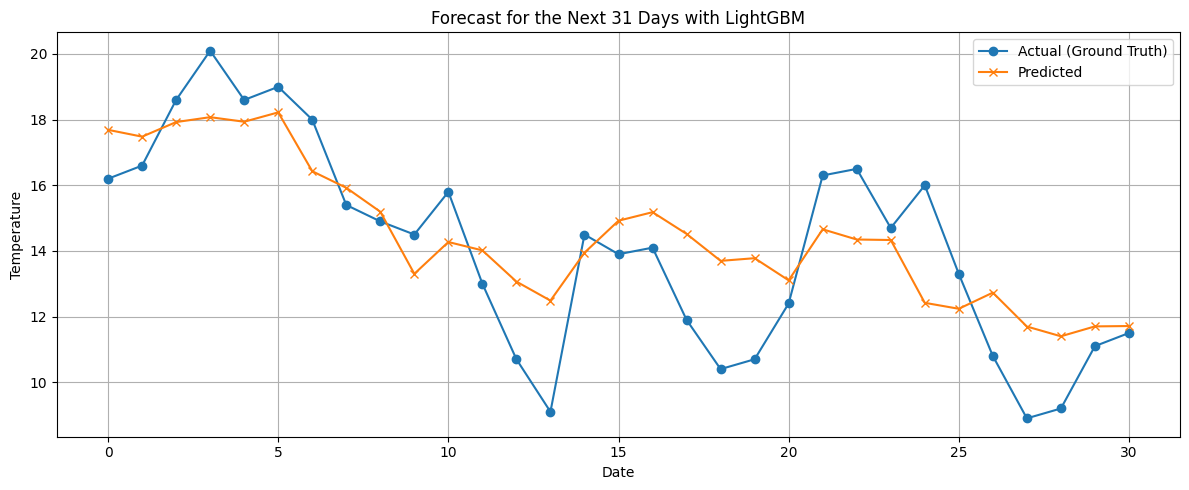

In [ ]:
# File name to store the best parameters
BEST_LGBM_PARAMS_FILE = "best_lgbm_params.json"

# Check if the parameter file exists
if not os.path.exists(BEST_LGBM_PARAMS_FILE):
    print("No optimal parameters found! Please run Optuna first")
    exit()

# Load the best parameters from the file
with open(BEST_LGBM_PARAMS_FILE, "r") as f:
    best_params = json.load(f)
    print(f"Loaded best parameters: {best_params}")

# Initialize the model with the saved parameters
best_model_lgb = lgb.LGBMRegressor(**best_params, random_state=42, n_jobs=-1)
best_model_lgb.fit(X_train_reduced_gbm, y_train_gbm)

# Make predictions on the test set
y_pred = best_model_lgb.predict(X_test_reduced_gbm)

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual (Ground Truth)', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("Forecast for the Next 31 Days with LightGBM")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

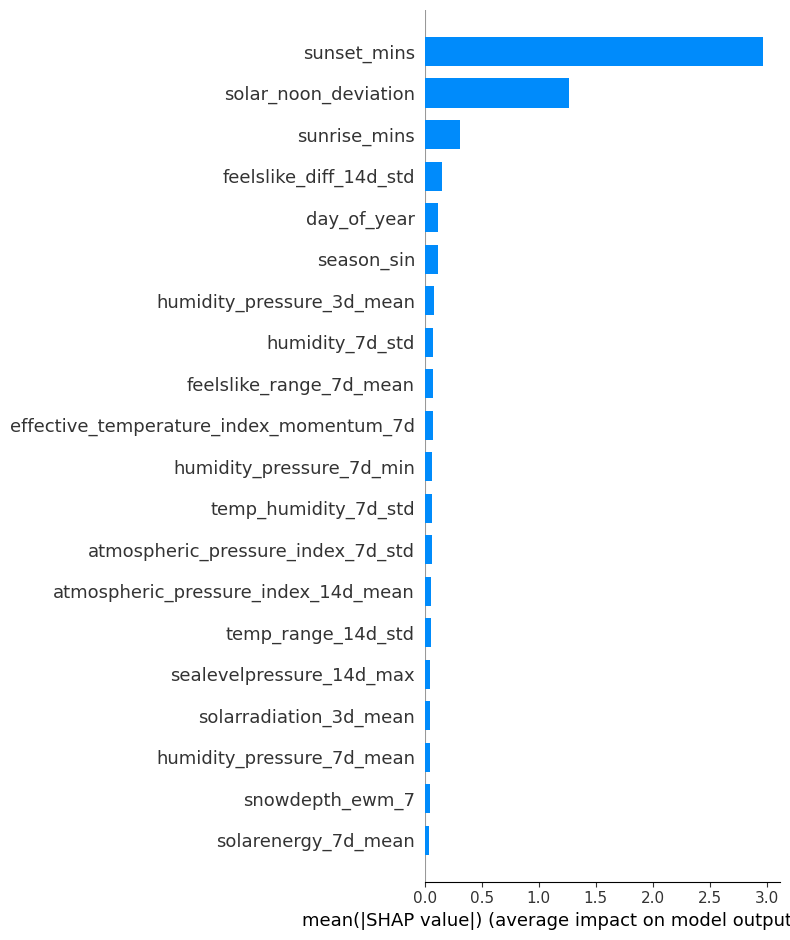

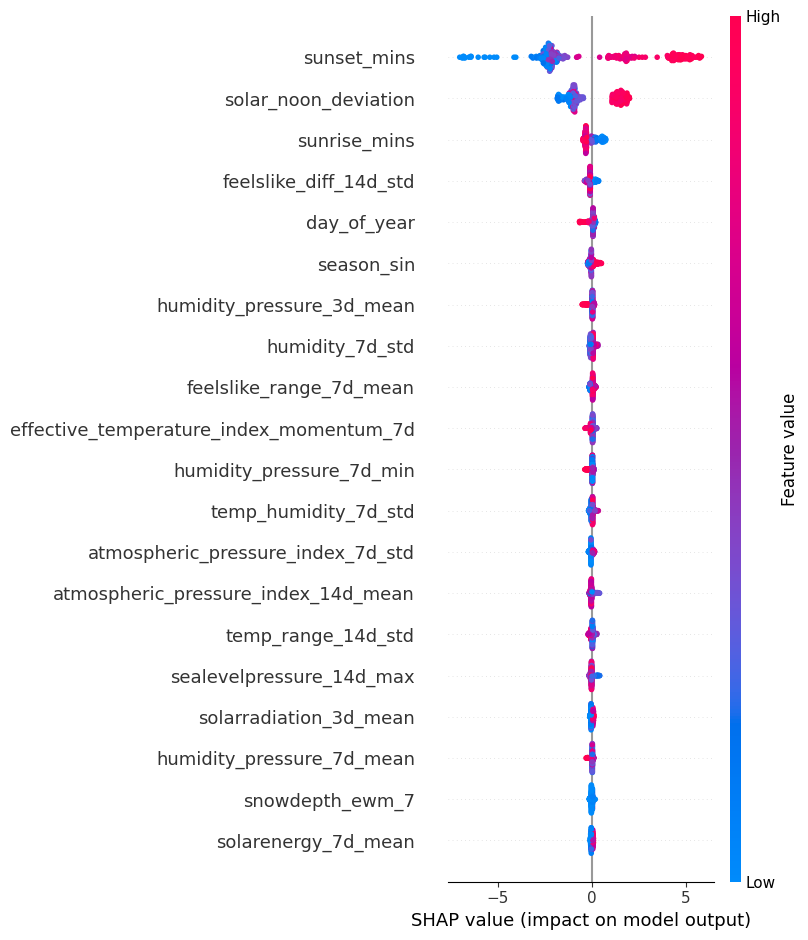

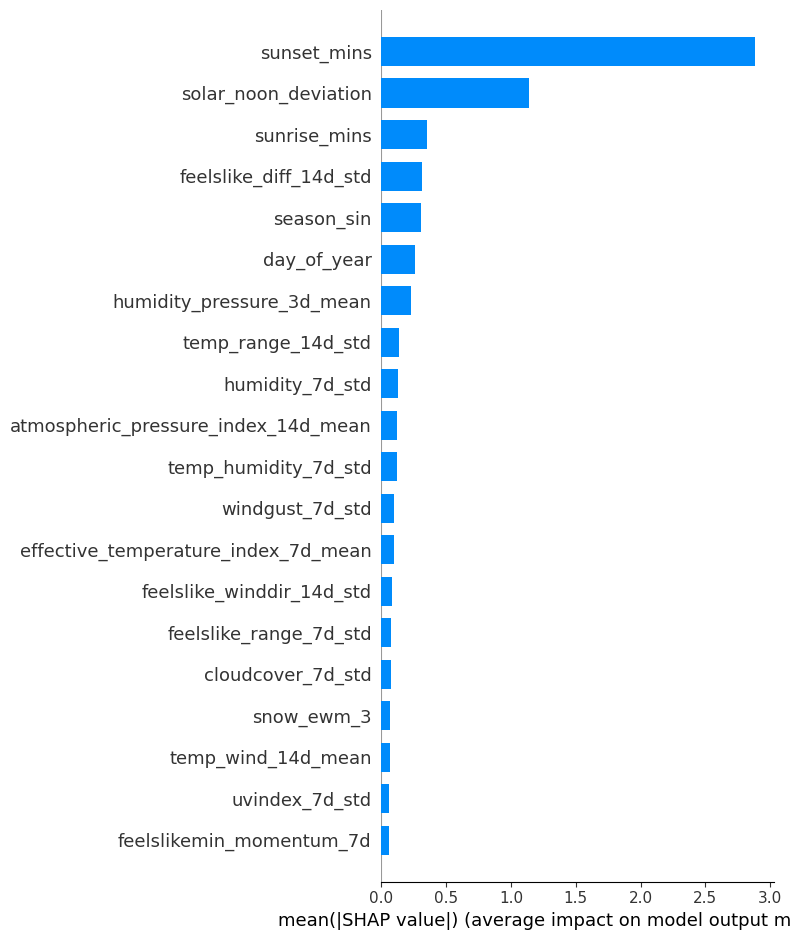

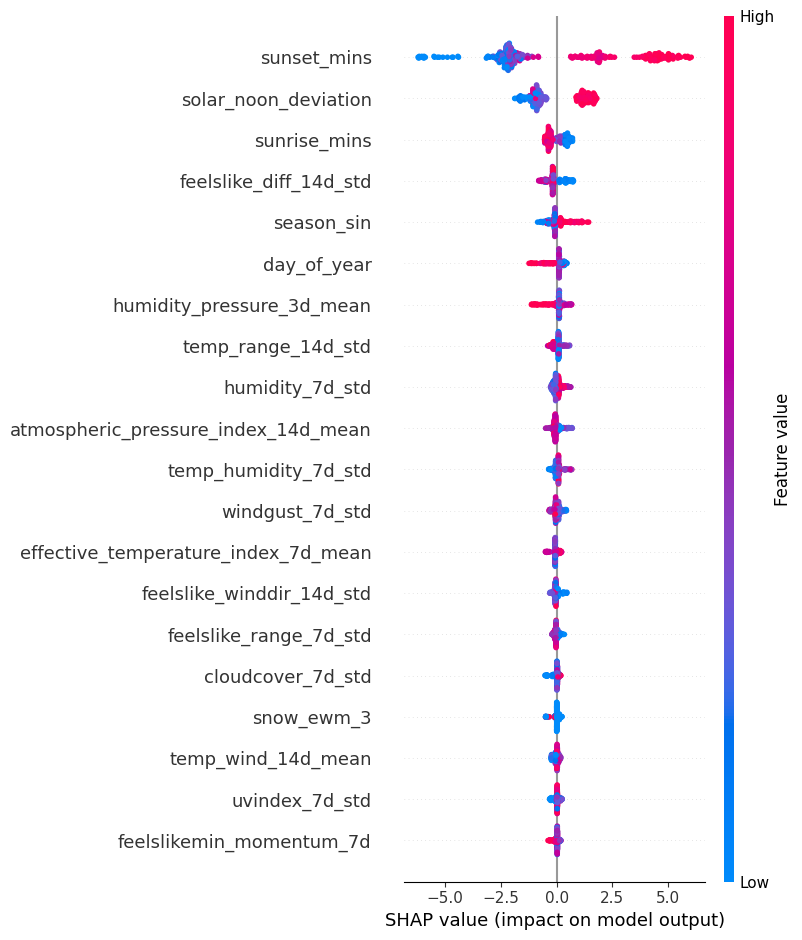

In [ ]:
import shap

#RF
feature_names = X_train_reduced.columns
explainer = shap.TreeExplainer(best_model_rf)
shap_values = explainer.shap_values(X_train_reduced)
shap.summary_plot(shap_values, X_train_reduced, plot_type="bar", feature_names=feature_names)
shap.summary_plot(shap_values, X_train_reduced, feature_names=feature_names)

#LightGBM
feature_names = X_train_reduced_gbm.columns
explainer = shap.TreeExplainer(best_model_lgb)
shap_values = explainer.shap_values(X_train_reduced_gbm)
shap.summary_plot(shap_values, X_train_reduced_gbm, plot_type="bar", feature_names=feature_names)
shap.summary_plot(shap_values, X_train_reduced_gbm, feature_names=feature_names)

### Comment on important features
- *sunset_mins*:  

There are many red points on the right → When sunset_mins is high (the sun sets later), the model predicts a higher temperature.

There are many blue points on the left → When sunset_mins is low (the sun sets earlier), the model predicts a lower temperature.
  
  
- *solarradiation_deviation*:

Large spread from negative to positive.

When this deviation is large (pink points), it appears more likely to shift predictions up. When smaller (blue points), it can reduce the prediction
  
- *sunrise_mins*:

Similar dynamic to sunset. A later sunrise (high value) might have a specific effect on the target, pushing the prediction higher. An earlier sunrise might lower the prediction.

- *feelslike_diff_14d_std*:

Moderate to large effect: The standard deviation in “feels-like” temperature over a 14-day window could indicate how volatile or stable conditions have been. A high volatility (pink) may increase the target, while low volatility (blue) might reduce it.


### Key Takeaways

Sunset, sunrise, and solar noon metrics stand out as very strong drivers in the model, with high feature values often increasing predictions.


Seasonality (day_of_year, season_sin) and feels-like temperature measures also play an important role but to a slightly lesser extent.

## **7. WEEKLY AVERAGING**

In [ ]:
df_train = df_train_7
df_test = df_test_7

In [ ]:
df_train.set_index('datetime', inplace=True)
df_test.set_index('datetime', inplace=True)

In [ ]:
def resample_weekly(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.set_index("datetime")

    numeric_cols = df.select_dtypes(include=['number']).columns
    object_cols = df.select_dtypes(include=['object', 'category']).columns
    datetime_cols = df.select_dtypes(include=['datetime']).columns

    df_numeric = df[numeric_cols].resample('7D').mean()
    df_object = df[object_cols].resample('7D').agg(lambda x: x.mode()[0] if not x.mode().empty else None)
    df_datetime = df[datetime_cols].resample('7D').first()

    df_resampled = pd.concat([df_numeric, df_object, df_datetime], axis=1)

    return df_resampled

df_train_weekly = resample_weekly(df_train)
df_test_weekly = resample_weekly(df_test)

In [ ]:
df_train_weekly, df_test_weekly = generate_interaction_features(df_train_weekly, df_test_weekly)

Interaction features added successfully:
Train data shape: (51, 54)
Test data shape: (5, 54)


In [ ]:
def handle_rolling_nan(df, columns_to_handle, strategy='bfill'):
    """
    Handles NaN values in specified columns of a DataFrame using a chosen strategy.

    Args:
        df (pd.DataFrame): Input DataFrame.
        columns_to_handle (list): List of column names to process for NaNs.
        strategy (str): Method to fill NaNs ('ffill', 'bfill', 'interpolate', 'zero', 'mean').

    Returns:
        pd.DataFrame: DataFrame with NaNs handled in the specified columns.
    """
    df_copy = df.copy()
    if not columns_to_handle:
        print("Warning: No rolling feature columns identified or provided for NaN handling.")
        return df_copy

    print(f"\nHandling NaNs in {len(columns_to_handle)} rolling features using strategy: {strategy}")

    if strategy == 'ffill':
        df_copy[columns_to_handle] = df_copy[columns_to_handle].fillna(method='ffill')
    elif strategy == 'bfill':
        df_copy[columns_to_handle] = df_copy[columns_to_handle].fillna(method='bfill')
    elif strategy == 'interpolate':
        df_copy[columns_to_handle] = df_copy[columns_to_handle].interpolate(method='linear', limit_direction='both') # limit_direction='both' có thể hữu ích
    elif strategy == 'zero':
        df_copy[columns_to_handle] = df_copy[columns_to_handle].fillna(0)
    elif strategy == 'mean':
        for col in columns_to_handle:
            mean_val = df_copy[col].mean()
            df_copy[col] = df_copy[col].fillna(mean_val)
            if df_copy[col].isna().any(): # Xử lý trường hợp mean_val cũng là NaN (cột toàn NaN)
                 df_copy[col] = df_copy[col].fillna(0) # Hoặc một giá trị mặc định khác
    else:
        raise ValueError(f"Invalid NaN handling strategy: {strategy}")

    # Kiểm tra lại các NaN còn lại sau khi xử lý (quan trọng sau bfill/ffill ở đầu/cuối)
    remaining_nans = df_copy[columns_to_handle].isna().sum()
    remaining_nans = remaining_nans[remaining_nans > 0]
    if not remaining_nans.empty:
        print("\nWarning: Remaining NaN values after initial handling (might be at the start/end):")
        print(remaining_nans)
        # Cân nhắc thêm một bước fill thứ cấp nếu cần, ví dụ fill bằng 0 hoặc ffill/bfill lần nữa
        # df_copy[columns_to_handle] = df_copy[columns_to_handle].fillna(0) # Ví dụ: fill phần còn lại bằng 0
    else:
        print("No remaining NaN values detected in the handled rolling features.")

    return df_copy

def add_rolling_features(df, cols_to_process, target_col):
    df_out = df.copy()
    rolling_windows = [2]
    ewm_spans = [2]

    for col in cols_to_process:
        # Lag features
        df_out[f"{col}_lag_1"] = df_out[col].shift(1)

        # Rolling window features
        for window in rolling_windows:
            df_out[f"{col}_{window}w_mean"] = df_out[col].rolling(window=window, min_periods=1).mean()
            if window > 1:
                 df_out[f"{col}_{window}w_std"] = df_out[col].rolling(window=window, min_periods=1).std()

            if col == target_col or 'pressure' in col or 'humidity' in col:
                df_out[f"{col}_{window}w_min"] = df_out[col].rolling(window=window, min_periods=1).min()
                df_out[f"{col}_{window}w_max"] = df_out[col].rolling(window=window, min_periods=1).max()

        # Exponential weighted mean features
        for span in ewm_spans:
            df_out[f"{col}_ewm_{span}"] = df_out[col].ewm(span=span, adjust=True, min_periods=1).mean()

        # Difference features
        df_out[f"{col}_1w_diff"] = df_out[col].diff(periods=1)

        # Momentum features (Difference over longer periods)
        df_out[f"{col}_momentum_1w"] = df_out[col].diff(periods=1) #
        df_out[f"{col}_momentum_2w"] = df_out[col].diff(periods=2)
        df_out[f"{col}_momentum_3w"] = df_out[col].diff(periods=3)

    return df_out

def generate_rolling_features(df_train, df_test, nan_strategy='bfill'):
    train_copy = df_train.copy()
    test_copy = df_test.copy()

    numerical_cols_train = train_copy.select_dtypes(include=np.number).columns.tolist()
    target_col = 'temp' if 'temp' in numerical_cols_train else None

    cols_to_exclude = [col for col in numerical_cols_train if 'year' in col or \
                       'week' in col or 'season' in col or 'day' in col or \
                       'month' in col or '_sin' in col or '_cos' in col or \
                       'solstice' in col or 'absolute' in col]

    cols_to_process = [col for col in numerical_cols_train if col not in cols_to_exclude]
    print(f"Generating rolling features for {len(cols_to_process)} numerical columns.")

    initial_train_cols = set(train_copy.columns)
    initial_test_cols = set(test_copy.columns)

    max_lag = 3

    if len(train_copy) >= max_lag:
        buffer_rows = train_copy.tail(max_lag)
    else:
        print(f"Warning: Training data length ({len(train_copy)}) is less than max_lag ({max_lag}). Buffer might be incomplete.")
        buffer_rows = train_copy

    test_buffered = pd.concat([buffer_rows, test_copy], ignore_index=False)

    print("\nAdding rolling features to Training data...")
    train_with_features = add_rolling_features(train_copy, cols_to_process, target_col)
    print("Adding rolling features to Buffered Test data...")
    test_with_buffer_features = add_rolling_features(test_buffered, cols_to_process, target_col)

    test_with_features = test_with_buffer_features.iloc[max_lag:]

    test_with_features = test_with_features.loc[test_copy.index]

    train_rolling_cols_added = list(set(train_with_features.columns) - initial_train_cols)
    test_rolling_cols_added = list(set(test_with_features.columns) - initial_test_cols)

    if set(train_rolling_cols_added) != set(test_rolling_cols_added):
         print("Warning: Different sets of rolling features generated for train and test sets.")
         common_rolling_cols = list(set(train_rolling_cols_added) & set(test_rolling_cols_added))
         print(f"Handling NaNs only for {len(common_rolling_cols)} common rolling features.")
         cols_to_handle_train = common_rolling_cols
         cols_to_handle_test = common_rolling_cols
    else:
         cols_to_handle_train = train_rolling_cols_added
         cols_to_handle_test = test_rolling_cols_added

    print("\n--- Handling NaNs for Training Data ---")
    train_final = handle_rolling_nan(train_with_features, cols_to_handle_train, strategy=nan_strategy)
    print("\n--- Handling NaNs for Test Data ---")
    test_final = handle_rolling_nan(test_with_features, cols_to_handle_test, strategy=nan_strategy)

    print("\n--- Final Check ---")
    print(f"Train data shape after feature generation: {train_final.shape}")
    print(f"Test data shape after feature generation: {test_final.shape}")

    print("\nRemaining NaNs in final train data (should be 0 or very few):")
    print(train_final.isna().sum().sum())
    print("Remaining NaNs in final test data (should be 0 or very few):")
    print(test_final.isna().sum().sum())


    print("\nExample of generated rolling features:")
    print(cols_to_handle_train[:10])

    return train_final, test_final

df_train_weekly, df_test_weekly = generate_rolling_features(df_train_weekly, df_test_weekly)

Generating rolling features for 41 numerical columns.

Adding rolling features to Training data...
Adding rolling features to Buffered Test data...

--- Handling NaNs for Training Data ---


C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\698052712.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[f"{col}_momentum_1w"] = df_out[col].diff(periods=1) #
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\698052712.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[f"{col}_momentum_2w"] = df_out[col].diff(periods=2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\698052712.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi


Handling NaNs in 342 rolling features using strategy: bfill
No remaining NaN values detected in the handled rolling features.

--- Handling NaNs for Test Data ---

Handling NaNs in 342 rolling features using strategy: bfill
No remaining NaN values detected in the handled rolling features.

--- Final Check ---
Train data shape after feature generation: (51, 396)
Test data shape after feature generation: (5, 396)

Remaining NaNs in final train data (should be 0 or very few):
0
Remaining NaNs in final test data (should be 0 or very few):
0

Example of generated rolling features:
['feelslike_2w_mean', 'atmospheric_pressure_index_2w_std', 'cloudcover_2w_std', 'snowdepth_momentum_2w', 'wind_y_1w_diff', 'precipprob_2w_std', 'feelslikemax_2w_mean', 'solarradiation_momentum_2w', 'feelslike_winddir_momentum_1w', 'temp_wind_lag_1']


C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\698052712.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy[columns_to_handle] = df_copy[columns_to_handle].fillna(method='bfill')
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\698052712.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy[columns_to_handle] = df_copy[columns_to_handle].fillna(method='bfill')


In [ ]:
def enrich_weekly_time_features(train_df, test_df):
    all_seasons = ["winter", "spring", "summer", "autumn"]

    for df in [train_df, test_df]:
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)

        df['week_of_year'] = df.index.isocalendar().week
        df['year'] = df.index.year

        df['adjusted_week'] = np.where(
            (df['week_of_year'] == 1) & (df.index.month == 1) & (df['year'] == 2024),
            53,
            df['week_of_year']
        )

        df['adjusted_year'] = np.where(df['adjusted_week'] == 53, df['year'] - 1, df['year'])

        df['absolute_week'] = (df['adjusted_year'] - 2023) * 53 + df['adjusted_week']

        df['week_sin'] = np.sin(2 * np.pi * df['adjusted_week'].astype(float) / 53.0)
        df['week_cos'] = np.cos(2 * np.pi * df['adjusted_week'].astype(float) / 53.0)

        solstice_week = 25
        df['solstice_distance_week'] = np.abs(df['adjusted_week'] - solstice_week)

        df['season'] = df['adjusted_week'].apply(
            lambda w: (
                "winter" if w <= 9 or w >= 49
                else "spring" if 10 <= w <= 22
                else "summer" if 23 <= w <= 35
                else "autumn"
            )
        )

        df['season'] = pd.Categorical(df['season'], categories=all_seasons, ordered=False)

        season_dummies = pd.get_dummies(df['season'], prefix='season', drop_first=False).astype(int)

        df.drop('season', axis=1, inplace=True)

        for col in season_dummies.columns:
             if col not in df.columns:
                 df[col] = season_dummies[col]
             else:
                 df[col] = season_dummies[col]

    return train_df, test_df

print(f"Columns in train_weekly after enrich: {df_train_weekly.shape[1]}")
print(f"Columns in test_weekly after enrich: {df_test_weekly.shape[1]}")

df_train_weekly, df_test_weekly = enrich_weekly_time_features(df_train_weekly, df_test_weekly)

Columns in train_weekly after enrich: 396
Columns in test_weekly after enrich: 396


C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\843376572.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['week_of_year'] = df.index.isocalendar().week
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\843376572.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['adjusted_week'] = np.where(
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\843376572.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [ ]:
import re
def add_sun_and_moon_features_weekly(train_df, test_df):
    def process(df):
        df["moonlight_intensity"] = np.sin(np.pi * df["moonphase"])
        df["moon_phase_angle"] = 2 * np.pi * df["moonphase"]
        df["moon_cos"] = np.cos(df["moon_phase_angle"])
        df["moon_sin"] = np.sin(df["moon_phase_angle"])

        df["sunrise"] = df["sunrise"].apply(lambda x: re.findall(r"\d{2}:\d{2}", str(x))[0] if re.findall(r"\d{2}:\d{2}", str(x)) else np.nan)
        df["sunset"] = df["sunset"].apply(lambda x: re.findall(r"\d{2}:\d{2}", str(x))[0] if re.findall(r"\d{2}:\d{2}", str(x)) else np.nan)

        df["sunrise_mins"] = df["sunrise"].str.split(":").str[0].astype(float) * 60 + \
                             df["sunrise"].str.split(":").str[1].astype(float)
        df["sunset_mins"] = df["sunset"].str.split(":").str[0].astype(float) * 60 + \
                            df["sunset"].str.split(":").str[1].astype(float)

        df["daylight_duration"] = df["sunset_mins"] - df["sunrise_mins"]
        df["solar_noon"] = df["sunrise_mins"] + df["daylight_duration"] / 2
        df["light_ratio"] = df["daylight_duration"] / (24 * 60)
        df["solar_noon_deviation"] = np.abs(df["solar_noon"] - 12 * 60)

        df["week_of_year"] = df.index.isocalendar().week.astype(int)

        df["season_encoded"] = df["week_of_year"].apply(
            lambda w: 0 if w <= 9 or w >= 49 else  # Winter
                      1 if 10 <= w <= 22 else      # Spring
                      2 if 23 <= w <= 35 else      # Summer
                      3                            # Autumn
        )

        df.drop(columns=["sunrise", "sunset"], inplace=True)

        return df

    train_df = process(train_df.copy())
    test_df = process(test_df.copy())

    max_daylight = train_df["daylight_duration"].max()
    train_df["normalized_daylight"] = train_df["daylight_duration"] / max_daylight
    test_df["normalized_daylight"] = test_df["daylight_duration"] / max_daylight

    return train_df, test_df

df_train_weekly, df_test_weekly = add_sun_and_moon_features_weekly(df_train_weekly, df_test_weekly)

In [ ]:
for df in [df_train_weekly, df_test_weekly]:
    if 'day' in df.columns:
        df.rename(columns={'day': 'original_day'}, inplace=True)
    if 'snow' in df.columns:
        df.rename(columns={'snow': 'original_snow'}, inplace=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def process_object_and_category(train_df, test_df):
    train_df = train_df.copy()
    test_df = test_df.copy()

    for df in [train_df, test_df]:
        df['preciptype'] = df['preciptype'].fillna('no precipitation')
        labels = ['no precipitation', 'rain', 'snow', 'freezingrain']
        for label in labels:
            df[f'precip_{label.replace(" ", "_")}'] = df['preciptype'].str.contains(label).astype(int)

    condition_weights = {
        'Clear': 2.0,
        'Partially cloudy': 1.0,
        'Overcast': -1.0,
        'Rain': -2.0,
        'Snow': -3.0,
        'Freezing Drizzle/Freezing Rain': -2.5
    }

    def compute_condition_score(conditions_str):
        if pd.isna(conditions_str):
            return 0
        score = 0
        for condition, weight in condition_weights.items():
            if condition in conditions_str:
                score += weight
        return score

    for df in [train_df, test_df]:
        df['condition_temp_score'] = df['new_conditions'].apply(compute_condition_score)

    tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_train = tfidf.fit_transform(train_df['description'].fillna(''))
    tfidf_test = tfidf.transform(test_df['description'].fillna(''))

    tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf.get_feature_names_out(), index=train_df.index)
    tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names_out(), index=test_df.index)

    train_df = pd.concat([train_df.reset_index(drop=True), tfidf_train_df.reset_index(drop=True)], axis=1)
    test_df = pd.concat([test_df.reset_index(drop=True), tfidf_test_df.reset_index(drop=True)], axis=1)

    all_icons = pd.concat([train_df['icon'], test_df['icon']]).astype('category')
    all_icons = all_icons.cat.categories

    for df in [train_df, test_df]:
        df['icon'] = pd.Categorical(df['icon'], categories=all_icons)
        icon_dummies = pd.get_dummies(df['icon'], prefix='icon').astype(int)  # ép kiểu ở đây
        df.drop('icon', axis=1, inplace=True)
        df[icon_dummies.columns] = icon_dummies


    return train_df, test_df
df_train_weekly, df_test_weekly = process_object_and_category(df_train_weekly, df_test_weekly)

In [ ]:
cols_to_drop = ['name', 'preciptype', 'conditions', 'description', 'stations', 'new_conditions', 'sunrise', 'sunset']

df_train_weekly.drop(columns=cols_to_drop, inplace=True, errors='ignore')
df_test_weekly.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print("df_test_weekly index range:", df_test_weekly.index.min(), "->", df_test_weekly.index.max())
print("df_test_weekly shape:", df_test_weekly.shape)

df_test_weekly index range: 0 -> 4
df_test_weekly shape: (5, 427)


In [ ]:
print("Checking and Removing Multicollinearity from WEEKLY data")

target_col = 'temp'

if target_col in df_train_weekly.columns:
    feature_cols = df_train_weekly.columns.drop(target_col)
else:
    print(f"Warning: Target column '{target_col}' not found in df_train_weekly. Using all columns as features.")
    feature_cols = df_train_weekly.columns

numerical_feature_cols = df_train_weekly[feature_cols].select_dtypes(include=np.number).columns
print(f"Number of numerical features considered in WEEKLY data: {len(numerical_feature_cols)}")

print("Calculating correlation matrix on df_train_weekly...")
corr_matrix = df_train_weekly[numerical_feature_cols].corr()

correlation_threshold = 0.95
print(f"Correlation threshold for removal: {correlation_threshold}")

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

highly_correlated_pairs = [
    (column, index) for column in upper_tri.columns for index in upper_tri.index
    if pd.notna(upper_tri.loc[index, column]) and abs(upper_tri.loc[index, column]) > correlation_threshold
]

print(f"\nFound {len(highly_correlated_pairs)} feature pairs in WEEKLY data with correlation > {correlation_threshold}:")

cols_to_drop_multi = set()

if highly_correlated_pairs:
    mean_abs_corr = abs(corr_matrix).mean(axis=1)

    print("\nDeciding columns to remove based on mean absolute correlation (from df_train_weekly):")
    for col1, col2 in highly_correlated_pairs:
        if col1 in cols_to_drop_multi or col2 in cols_to_drop_multi:
            continue

        mean_corr1 = mean_abs_corr.get(col1, 0)
        mean_corr2 = mean_abs_corr.get(col2, 0)

        if mean_corr1 > mean_corr2:
            col_to_remove = col1
            print(f"- Between '{col1}' ({mean_corr1:.3f}) and '{col2}' ({mean_corr2:.3f}), removing '{col_to_remove}' (higher mean correlation)")
            cols_to_drop_multi.add(col_to_remove)
        else:
            col_to_remove = col2
            print(f"- Between '{col1}' ({mean_corr1:.3f}) and '{col2}' ({mean_corr2:.3f}), removing '{col_to_remove}' (higher or equal mean correlation)")
            cols_to_drop_multi.add(col_to_remove)
else:
    print("\nNo feature pairs in WEEKLY data exceed the correlation threshold for removal.")

cols_to_drop_multi_list = list(cols_to_drop_multi)
if cols_to_drop_multi_list:
    print(f"\nColumns identified for removal due to multicollinearity: {cols_to_drop_multi_list}")

    train_weekly_cols_before = df_train_weekly.shape[1]
    test_weekly_cols_before = df_test_weekly.shape[1]

    df_train_weekly.drop(columns=cols_to_drop_multi_list, inplace=True, errors='ignore')
    df_test_weekly.drop(columns=cols_to_drop_multi_list, inplace=True, errors='ignore')

    print(f"\nRemoved {len(cols_to_drop_multi_list)} columns from WEEKLY data.")
    print(f"df_train_weekly shape: {train_weekly_cols_before} columns -> {df_train_weekly.shape[1]} columns")
    print(f"df_test_weekly shape: {test_weekly_cols_before} columns -> {df_test_weekly.shape[1]} columns")
else:
    print("\nNo columns removed from WEEKLY data due to multicollinearity.")

print("\nMulticollinearity Check on WEEKLY data Completed")

Checking and Removing Multicollinearity from WEEKLY data
Number of numerical features considered in WEEKLY data: 426
Calculating correlation matrix on df_train_weekly...
Correlation threshold for removal: 0.95

Found 832 feature pairs in WEEKLY data with correlation > 0.95:

Deciding columns to remove based on mean absolute correlation (from df_train_weekly):
- Between 'tempmin' (0.367) and 'tempmax' (0.375), removing 'tempmax' (higher or equal mean correlation)
- Between 'feelslikemax' (0.375) and 'tempmin' (0.367), removing 'feelslikemax' (higher mean correlation)
- Between 'feelslikemin' (0.370) and 'tempmin' (0.367), removing 'feelslikemin' (higher mean correlation)
- Between 'feelslike' (0.374) and 'tempmin' (0.367), removing 'feelslike' (higher mean correlation)
- Between 'dew' (0.360) and 'tempmin' (0.367), removing 'tempmin' (higher or equal mean correlation)
- Between 'windspeed' (0.273) and 'windgust' (0.247), removing 'windspeed' (higher mean correlation)
- Between 'solarene

In [ ]:
target_col = 'temp'

lag_weeks = 5

X_train_shifted = df_train_weekly.drop(columns=[target_col]).shift(lag_weeks)
y_train = df_train_weekly[target_col]

X_train = X_train_shifted.iloc[lag_weeks:].reset_index(drop=True)
y_train = y_train.iloc[lag_weeks:].reset_index(drop=True)

X_test_features_base = df_train_weekly.drop(columns=[target_col]).iloc[-lag_weeks:].reset_index(drop=True)

last_week_train_features = df_train_weekly.drop(columns=[target_col]).iloc[-1]

alpha = 0.4

X_test = (X_test_features_base * (1 - alpha)) + (last_week_train_features * alpha)

y_test = df_test_weekly[target_col].iloc[:lag_weeks].reset_index(drop=True)

### **7.1 Fit Random Forest**

In [ ]:
X_train_weekly_reduced, X_test_weekly_reduced, y_train_weekly_rf = process_and_select_features(X_train, y_train, X_test=X_test, threshold=0.0001) #RF

Selected 177 important features out of 236
Reduced training dataset shape: (46, 177)
Reduced test dataset shape: (5, 177)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

model = RandomForestRegressor(random_state=42, n_estimators=50)

model.fit(X_train_weekly_reduced, y_train_weekly_rf)

y_train_pred = model.predict(X_train_weekly_reduced)

y_test_pred = model.predict(X_test_weekly_reduced)

rmse_train = np.sqrt(mean_squared_error(y_train_weekly_rf, y_train_pred))
r2_train = r2_score(y_train_weekly_rf, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train_weekly_rf, y_train_pred)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print("Evaluation")
print(f"Train RMSE: {rmse_train:.3f} | Test RMSE: {rmse_test:.3f}")
print(f"Train R² Score: {r2_train:.3f} | Test R² Score: {r2_test:.3f}")
print(f"Train MAPE: {mape_train:.3%} | Test MAPE: {mape_test:.3%}")

Evaluation
Train RMSE: 1.221 | Test RMSE: 3.333
Train R² Score: 0.956 | Test R² Score: -0.797
Train MAPE: 158.524% | Test MAPE: 24.681%


In [ ]:
import optuna
import json
import os

# File name for saving best RF parameters
BEST_RF_7_PARAMS_FILE = "best_rf_7_params.json"

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return rmse, r2, mape

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000, step=50)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.05, 1.0)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    rmse, _, _ = evaluate_model(model, X_test, y_test)
    return rmse

study = optuna.create_study(direction='minimize', study_name="rf_experiment")
study.optimize(objective, n_trials=50)

# Get best parameters from this run
new_best_params = study.best_params
print("Optimization results for this run:", new_best_params)

# Read best parameters from previous runs
if os.path.exists(BEST_RF_7_PARAMS_FILE):
    with open(BEST_RF_7_PARAMS_FILE, "r") as f:
        saved_best_params = json.load(f)
        print("Best parameters from previous runs:", saved_best_params)
else:
    saved_best_params = None

# Compare models
print("\nRetraining the model for comparison...")

# Train new model
new_model = RandomForestRegressor(**new_best_params, random_state=42, n_jobs=-1)
new_model.fit(X_train_weekly_reduced, y_train_weekly_rf)
new_rmse, new_r2, new_mape = evaluate_model(new_model, X_test_weekly_reduced, y_test)

# Train old model if available
if saved_best_params:
    old_model = RandomForestRegressor(**saved_best_params, random_state=42, n_jobs=-1)
    old_model.fit(X_train_weekly_reduced, y_train_weekly_rf)
    old_rmse, old_r2, old_mape = evaluate_model(old_model, X_test_weekly_reduced, y_test)

    print("\nModel comparison:")
    print(f"New model:   RMSE = {new_rmse:.3f}, R² = {new_r2:.3f}, MAPE = {new_mape:.3%}")
    print(f"Previous model:   RMSE = {old_rmse:.3f}, R² = {old_r2:.3f}, MAPE = {old_mape:.3%}")

    # If the new model is better (lower RMSE), update the best parameters
    if new_rmse < old_rmse:
        print("New model is BETTER! Updating best parameters.")
        with open(BEST_RF_7_PARAMS_FILE, "w") as f:
            json.dump(new_best_params, f)
    else:
        print("Previous model is still better. Keeping old parameters.")
else:
    print(f"No previous model found. Saving new best parameters!")
    with open(BEST_RF_7_PARAMS_FILE, "w") as f:
        json.dump(new_best_params, f)

print("\nProcess completed!")

[I 2025-04-02 10:58:24,853] A new study created in memory with name: rf_experiment
[I 2025-04-02 10:58:25,472] Trial 0 finished with value: 2.5483943145395065 and parameters: {'n_estimators': 550, 'max_depth': 11, 'min_samples_split': 29, 'min_samples_leaf': 19, 'max_features': 0.8187360640148313}. Best is trial 0 with value: 2.5483943145395065.
[I 2025-04-02 10:58:26,643] Trial 1 finished with value: 4.449915771674958 and parameters: {'n_estimators': 800, 'max_depth': 7, 'min_samples_split': 24, 'min_samples_leaf': 7, 'max_features': 0.49258626159179975}. Best is trial 0 with value: 2.5483943145395065.
[I 2025-04-02 10:58:27,871] Trial 2 finished with value: 4.269792578899548 and parameters: {'n_estimators': 1000, 'max_depth': 37, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 0.33475736648169446}. Best is trial 0 with value: 2.5483943145395065.
[I 2025-04-02 10:58:28,823] Trial 3 finished with value: 2.8518474003337126 and parameters: {'n_estimators': 950, 'max_depth'

Optimization results for this run: {'n_estimators': 950, 'max_depth': 4, 'min_samples_split': 32, 'min_samples_leaf': 7, 'max_features': 0.5178044229978238}
Best parameters from previous runs: {'n_estimators': 150, 'max_depth': 23, 'min_samples_split': 33, 'min_samples_leaf': 9, 'max_features': 0.40106882547254125}

Retraining the model for comparison...

Model comparison:
New model:   RMSE = 2.475, R² = 0.009, MAPE = 13.420%
Previous model:   RMSE = 2.466, R² = 0.016, MAPE = 12.831%
Previous model is still better. Keeping old parameters.

Process completed!


Loaded best parameters: {'n_estimators': 150, 'max_depth': 23, 'min_samples_split': 33, 'min_samples_leaf': 9, 'max_features': 0.40106882547254125}


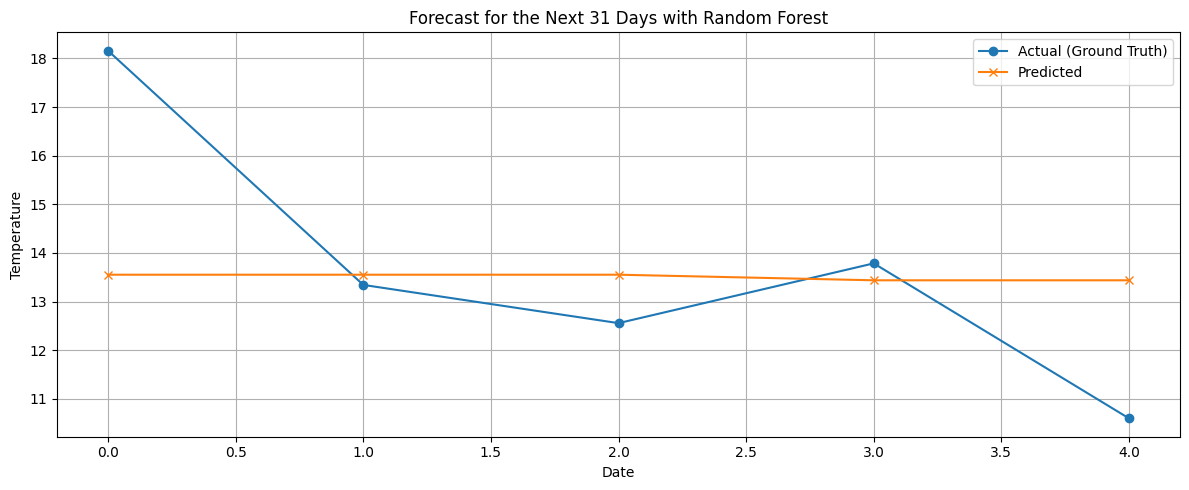

In [ ]:
# Check if the parameter file exists
if not os.path.exists(BEST_RF_7_PARAMS_FILE):
    print("No optimal parameters found! Please run Optuna first.")
    exit()

# Load the best parameters from the file
with open(BEST_RF_7_PARAMS_FILE, "r") as f:
    best_params = json.load(f)
    print(f"Loaded best parameters: {best_params}")

# Initialize the model with the saved parameters
best_model_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_model_rf.fit(X_train_weekly_reduced, y_train_weekly_rf)

# Make predictions on the test set
y_pred = best_model_rf.predict(X_test_weekly_reduced)

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual (Ground Truth)', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("Forecast for the Next 31 Days with Random Forest")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **7.2 Fit LightGBM**

In [ ]:
X_train_weekly_reduced_gbm, X_test_weekly_reduced_gbm, y_train_weekly_gbm = process_and_select_features_lgbm(X_train, y_train, X_test=X_test, threshold=0.0001) #lightgbm

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3138
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 198
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
model = lgb.LGBMRegressor(random_state=42, n_estimators=30)

# Fit for train
model.fit(X_train_weekly_reduced_gbm, y_train_weekly_gbm)

# Predict for train
y_train_pred = model.predict(X_train_weekly_reduced_gbm)

# Predict for test
y_test_pred = model.predict(X_test_weekly_reduced_gbm)

# Metrics for train
rmse_train = np.sqrt(mean_squared_error(y_train_weekly_gbm, y_train_pred))
r2_train = r2_score(y_train_weekly_gbm, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train_weekly_gbm, y_train_pred)

# Metrics for test
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

# result
print("Evaluatetion for LightGBM:")
print(f"Train RMSE: {rmse_train:.3f} | Test RMSE: {rmse_test:.3f}")
print(f"Train R² Score: {r2_train:.3f} | Test R² Score: {r2_test:.3f}")
print(f"Train MAPE: {mape_train:.3%} | Test MAPE: {mape_test:.3%}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 30
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
# File name for saving best LGB parameters
BEST_LGBM_7_PARAMS_FILE = "best_lgbm_7_params.json"

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return rmse, r2, mape

def objective(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 10, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=50),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 50),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 10),
    }

    model = lgb.LGBMRegressor(**params, random_state=42, n_jobs=-1)
    model.fit(X_train_weekly_reduced_gbm, y_train_weekly_gbm)

    rmse, _, _ = evaluate_model(model, X_test_weekly_reduced_gbm, y_test)
    return rmse

study = optuna.create_study(direction="minimize", study_name="lgbm_experiment")
study.optimize(objective, n_trials=50)

# Get best parameters from this run
new_best_params = study.best_params
print("Optimization results for this run:", new_best_params)

# Read best parameters from previous runs
if os.path.exists(BEST_LGBM_7_PARAMS_FILE):
    with open(BEST_LGBM_7_PARAMS_FILE, "r") as f:
        saved_best_params = json.load(f)
        print("Best parameters from previous runs:", saved_best_params)
else:
    saved_best_params = None

# Compare models
print("\nRetraining the model for comparison...")

# Train new model
new_model = lgb.LGBMRegressor(**new_best_params, random_state=42, n_jobs=-1)
new_model.fit(X_train_weekly_reduced_gbm, y_train_weekly_gbm)
new_rmse, new_r2, new_mape = evaluate_model(new_model, X_test_weekly_reduced_gbm, y_test)

# Train old model if available
if saved_best_params:
    old_model = lgb.LGBMRegressor(**saved_best_params, random_state=42, n_jobs=-1)
    old_model.fit(X_train_weekly_reduced_gbm, y_train_weekly_gbm)
    old_rmse, old_r2, old_mape = evaluate_model(old_model, X_test_weekly_reduced_gbm, y_test)

    print("\nModel comparison:")
    print(f"New model:   RMSE = {new_rmse:.3f}, R² = {new_r2:.3f}, MAPE = {new_mape:.3%}")
    print(f"Previous model:   RMSE = {old_rmse:.3f}, R² = {old_r2:.3f}, MAPE = {old_mape:.3%}")

    # If the new model is better (lower RMSE), update the best parameters
    if new_rmse < old_rmse:
        print("New model is BETTER! Updating best parameters.")
        with open(BEST_LGBM_7_PARAMS_FILE, "w") as f:
            json.dump(new_best_params, f)
    else:
        print("Previous model is still better. Keeping old parameters.")
else:
    print(f"No previous model found. Saving new best parameters!")
    with open(BEST_LGBM_7_PARAMS_FILE, "w") as f:
        json.dump(new_best_params, f)

print("\nProcess completed!")

[I 2025-04-02 10:58:53,390] A new study created in memory with name: lgbm_experiment
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 30
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-04-02 10:58:53,979] Trial 11 finished with value: 2.7688162061526556 and parameters: {'num_leaves': 468, 'max_depth': 12, 'learning_rate': 0.03846118090478671, 'n_estimators': 350, 'min_child_samples': 7, 'subsample': 0.3974362190422731, 'colsample_bytree': 0.38637719245757374, 'reg_alpha': 1.4088200168910083e-05, 'reg_lambda': 0.0753428918737246}. Best is trial 7 with value: 2.354473009156389.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 30
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 30
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 10),
[I 2025-04-02 10:58:54,132] Trial 13 finished with value: 3.6481315184971854 and parameters: {'num_leaves': 150, 'max_depth': 50, 'learning_rate': 0.075123170861942, 'n_estimators': 50, 'min_child_samples': 16, 'subsample': 0.9790125829043768, 'colsample_bytree': 0.4218366286077985, 'reg_alpha': 0.21634984894800785, 'reg_l

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 30
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-04-02 10:58:54,263] Trial 14 finished with value: 5.384803614576494 and parameters: {'num_leaves': 413, 'max_depth': 3, 'learning_rate': 0.25942737375418734, 'n_estimators': 350, 'min_child_samples': 17, 'subsample': 0.835353654195736, 'colsample_bytree': 0.7139126179936789, 'reg_alpha': 0.00011542155420356541, 'reg_lambda': 0.00015930734892356555}. Best is trial 7 with value: 2.354473009156389.
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 10),


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 30
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-04-02 10:58:54,618] Trial 15 finished with value: 2.9141267920117744 and parameters: {'num_leaves': 235, 'max_depth': 11, 'learning_rate': 0.016071289339694848, 'n_estimators': 650, 'min_child_samples': 1, 'subsample': 0.43836466321069134, 'colsample_bytree': 0.90808558824897, 'reg_alpha': 0.002965953404812901, 'reg_lambda': 0.8466792377378806}. Best is trial 7 with value: 2.354473009156389.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 30
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 30
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-04-02 10:58:55,158] Trial 22 finished with value: 2.5585125073013173 and parameters: {'num_leaves': 302, 'max_depth': 30, 'learning_rate': 0.020131767039013006, 'n_estimators': 500, 'min_child_samples': 38, 'subsample': 0.7727798577442606, 'colsample_bytree': 0.28359062264542734, 'reg_alpha': 0.04319006534245844, 'reg_lambda': 0.5720343048813581}. Best is trial 7 with value: 2.354473009156389.


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[I 2025-04-02 10:58:55,372] Trial 25 finished with value: 4.758367586695033 and parameters: {'num_leaves': 94, 'max_depth': 40, 'learning_rate': 0.06721202989933692, 'n_estimators': 400, 'min_child_samples': 18, 'subsample': 0.10993418210556061, 'colsample_bytree': 0.37475326355464894, 'reg_alpha': 0.01583705960454871, 'reg_lambda': 0.0004899715694548225}. Best is trial 7 with value: 2.354473009156389.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[I 2025-04-02 10:58:55,649] Trial 28 finished with value: 3.8362917916715724 and parameters: {'num_leaves': 277, 'max_depth': 45, 'learning_rate': 0.027195450319662355, 'n_estimators': 500, 'min_child_samples': 13, 'subsample': 0.5513895537549652, 'colsample_bytree': 0.18036928690569073, 'reg_alpha': 0.00036513623695380267, 'reg_lambda': 2.5650535937351004}. Best is trial 7 with value: 2.354473009156389.
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 30
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-04-02 10:58:55,780] Trial 29 finished with value: 5.761555629869549 and parameters: {'num_leaves': 346, 'max_depth': 37, 'learning_rate': 0.008395044070367159, 'n_estimators': 800, 'min_child_samples': 20, 'subsample': 0.6829010060659862, 'colsample_bytree': 0.7789845980345976, 'reg_alpha': 0.0026497784923318625, 'reg_lambda': 0.0008269382711382939}. Best is trial 7 with value: 2.354473009156389.
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stop

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 464
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 29
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-04-02 10:58:56,399] Trial 36 finished with value: 2.6652037833095767 and parameters: {'num_leaves': 35, 'max_depth': 6, 'learning_rate': 0.29008309957396733, 'n_estimators': 750, 'min_child_samples': 5, 'subsample': 0.28191882765517357, 'colsample_bytree': 0.5903026853448665, 'reg_alpha': 0.009279694779698417, 'reg_lambda': 3.480517754320348e-05}. Best is trial 7 with value: 2.354473009156389.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 30
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 10),
[I 2025-04-02 10:58:56,917] Trial 43 finished with value: 2.5585125073013173 and parameters: {'num_leaves': 425, 'max_depth': 36, 'learning_rate': 0.035746622009079985, 'n_estimators': 400, 'min_child_samples': 36, 'subsample': 0.22974751396996201, 'colsample_bytree': 0.7314001504817567, 'reg_alpha': 1.1638586638444039e-05

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 0
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10),
C:\Users\Admin\AppData\Local\Temp\ipykernel_22920\4271857007.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("r

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 30
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Loaded best parameters: {'num_leaves': 38, 'max_depth': 45, 'learning_rate': 0.006270837925531064, 'n_estimators': 150, 'min_child_samples': 15, 'subsample': 0.899267835084256, 'colsample_bytree': 0.16144345814581185, 'reg_alpha': 0.18181000562520247, 'reg_lambda': 1.878007831126515}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 30
[LightGBM] [Info] Start training from score 13.086335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

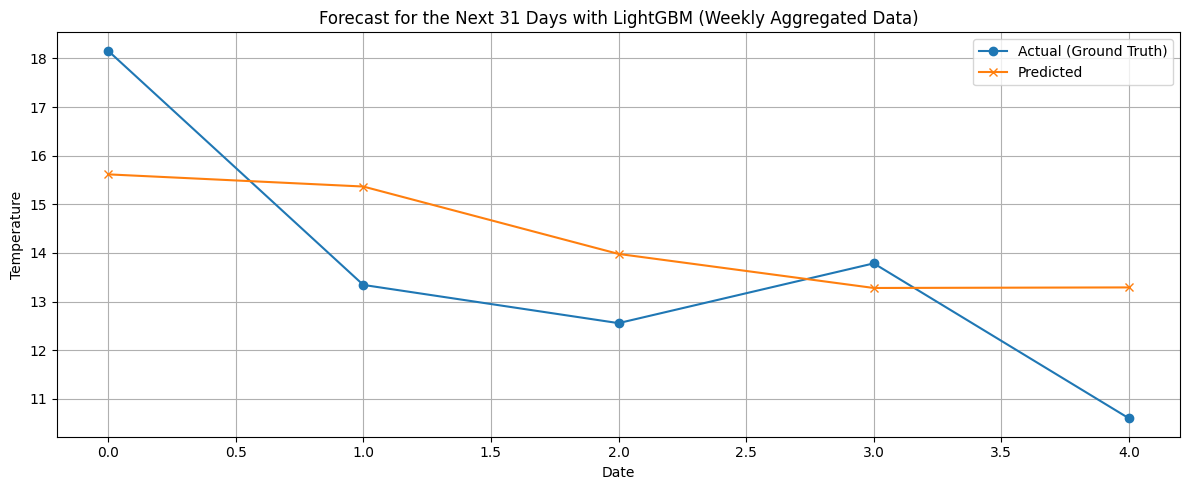

In [ ]:
# File name to store the best parameters
BEST_LGBM_7_PARAMS_FILE = "best_lgbm_7_params.json"

# Check if the parameter file exists
if not os.path.exists(BEST_LGBM_7_PARAMS_FILE):
    print("No optimal parameters found! Please run Optuna first")
    exit()

# Load the best parameters from the file
with open(BEST_LGBM_7_PARAMS_FILE, "r") as f:
    best_params = json.load(f)
    print(f"Loaded best parameters: {best_params}")

# Initialize the model with the saved parameters
best_model_lgb = lgb.LGBMRegressor(**best_params, random_state=42, n_jobs=-1)
best_model_lgb.fit(X_train_weekly_reduced_gbm, y_train_weekly_gbm)

# Make predictions on the test set
y_pred = best_model_lgb.predict(X_test_weekly_reduced_gbm)

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual (Ground Truth)', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("Forecast for the Next 31 Days with LightGBM (Weekly Aggregated Data)")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Weekly forecasting focuses on long-term trends and requires less data. However, it may miss important short-term fluctuations. Therefore, the result might not as good as daily forecasting